In [75]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import random  # Para inicializar pesos aleatórios
import networkx as nx  # Para visualização do grafo da MLP
import matplotlib.pyplot as plt  # Para plotar a estrutura da rede e gráficos
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [76]:
import math

class ActivationFunctions:
    @staticmethod
    def relu(x):
        """
        ReLU (Rectified Linear Unit) function.
        :param x: Single value or list of values.
        :return: max(0, x) for each value.
        """
        if isinstance(x, list):
            return [max(0, value) for value in x]
        return max(0, x)

    @staticmethod
    def relu_derivative(x):
        """
        Derivative of ReLU function.
        :param x: Single value or list of values.
        :return: 1 if x > 0, else 0 for each value.
        """
        if isinstance(x, list):
            return [1 if value > 0 else 0 for value in x]
        return 1 if x > 0 else 0

    @staticmethod
    def linear(x):
        """
        Linear activation function.
        :param x: Single value or list of values.
        :return: x (identity function).
        """
        if isinstance(x, list):
            return x
        return x

    @staticmethod
    def linear_derivative(x):
        """
        Derivative of the linear function.
        :param x: Single value or list of values.
        :return: 1 for any input.
        """
        if isinstance(x, list):
            return [1 for _ in x]
        return 1

    @staticmethod
    def sigmoid(x):
        """
        Sigmoid activation function.
        :param x: Single value or list of values.
        :return: 1 / (1 + exp(-x)) for each value.
        """
        if isinstance(x, list):
            return [1 / (1 + math.exp(-value)) for value in x]
        return 1 / (1 + math.exp(-x))

    @staticmethod
    def sigmoid_derivative(x):
        """
        Derivative of the sigmoid function.
        :param x: Single value or list of values.
        :return: sigmoid(x) * (1 - sigmoid(x)) for each value.
        """
        sigmoid_value = ActivationFunctions.sigmoid(x)
        if isinstance(x, list):
            return [value * (1 - value) for value in sigmoid_value]
        return sigmoid_value * (1 - sigmoid_value)

In [77]:
# Testar com valores únicos
print(ActivationFunctions.relu(-5))  # Saída esperada: 0
print(ActivationFunctions.relu(5))   # Saída esperada: 5
print(ActivationFunctions.relu_derivative(-5))  # Saída esperada: 0
print(ActivationFunctions.relu_derivative(5))   # Saída esperada: 1
print(ActivationFunctions.linear(10))  # Saída esperada: 10
print(ActivationFunctions.linear_derivative(10))  # Saída esperada: 1
print(ActivationFunctions.sigmoid(-5))  # Saída esperada: 0.0066928509242848554
print(ActivationFunctions.sigmoid(5))   # Saída esperada: 0.9933071490757153
print(ActivationFunctions.sigmoid_derivative(-5))  # Saída esperada: 0.006648056288095992
print(ActivationFunctions.sigmoid_derivative(5))   # Saída esperada: 0.006648056288095992

# Testar com listas
print(ActivationFunctions.relu([-5, 5, 0]))  # Saída esperada: [0, 5, 0]
print(ActivationFunctions.relu_derivative([-5, 5, 0]))  # Saída esperada: [0, 1, 0]
print(ActivationFunctions.linear([10, -10, 0]))  # Saída esperada: [10, -10, 0]
print(ActivationFunctions.linear_derivative([10, -10, 0]))  # Saída esperada: [1, 1, 1]
print(ActivationFunctions.sigmoid([-5, 5, 0]))  # Saída esperada: [0.0066928509242848554, 0.9933071490757153, 0.5]
print(ActivationFunctions.sigmoid_derivative([-5, 5, 0]))  # Saída esperada: [0.006648056288095992, 0.006648056288095992, 0.25]

0
5
0
1
10
1
0.0066928509242848554
0.9933071490757153
0.006648056670790155
0.006648056670790033
[0, 5, 0]
[0, 1, 0]
[10, -10, 0]
[1, 1, 1]
[0.0066928509242848554, 0.9933071490757153, 0.5]
[0.006648056670790155, 0.006648056670790033, 0.25]


In [78]:
class MLP:
    def __init__(self, *layers, learning_rate=0.01, momentum=0.9):
        """
        Inicializa a estrutura da MLP.

        :param layers: Número de neurônios em cada camada, incluindo entrada, ocultas e saída.
        :param learning_rate: Taxa de aprendizado.
        :param momentum: Fator de momento para a descida do gradiente.
        """
        self.layers_sizes = layers
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.weights = []
        self.biases = []
        self.velocities_weights = []  # Velocidades para os pesos
        self.velocities_biases = []   # Velocidades para os vieses
        self.outputs = []
        self.initialize_network()

    def initialize_network(self):
        """
        Inicializa a rede criando as matrizes de pesos e vetores de bias entre as camadas.
        Também inicializa as velocidades (momentum) como zero.
        """
        for i in range(len(self.layers_sizes) - 1):
            input_neurons = self.layers_sizes[i]
            output_neurons = self.layers_sizes[i + 1]
            # Inicializar pesos aleatórios entre -1 e 1 com NumPy
            self.weights.append(np.random.uniform(-1, 1, (input_neurons, output_neurons)))
            # Inicializar biases aleatórios entre -1 e 1 com NumPy
            self.biases.append(np.random.uniform(-1, 1, output_neurons))
            # Inicializar velocidades como zeros
            self.velocities_weights.append(np.zeros((input_neurons, output_neurons)))
            self.velocities_biases.append(np.zeros(output_neurons))

    def calculate_z(self, inputs, weights, biases):
        """
        Calcula Z = W * X + b usando NumPy.
        """
        return np.dot(inputs, weights) + biases

    def forward_propagation(self, inputs):
        """
        Realiza a propagação para frente através da rede.
        """
        self.outputs = [np.array(inputs)]  # Certifique-se de que inputs é um vetor 1D

        current_output = self.outputs[0]
        for i in range(len(self.weights)):
            # Cálculo de Z = W * X + b
            z = self.calculate_z(current_output, self.weights[i], self.biases[i])

            # Ativação para camadas ocultas e saída
            if i < len(self.weights) - 1:  # Camadas ocultas
                current_output = np.maximum(0, z)  # ReLU
            else:  # Camada de saída
                current_output = z  # Linear para regressão

            # Armazenar a saída corretamente
            self.outputs.append(np.array(current_output))  # Certifique-se de que é um array

        return current_output


    def backward_propagation(self, expected_output):
        """
        Realiza a retropropagação do erro e atualiza os pesos e biases com suporte a mini-batches.
        Aplica momento para suavizar e acelerar as atualizações.
        """
        expected_output = np.array(expected_output)
        deltas = [None] * len(self.weights)

        # Cálculo dos deltas para a camada de saída
        errors = expected_output - self.outputs[-1]  # (batch_size, output_size)
        deltas[-1] = errors  # Derivada da função linear é 1

        # Retropropagar para camadas ocultas
        for i in range(len(self.weights) - 2, -1, -1):
            z_derivative = (self.outputs[i + 1] > 0).astype(float)  # Derivada da ReLU
            deltas[i] = np.dot(deltas[i + 1], self.weights[i + 1].T) * z_derivative

        # Atualizar pesos e biases com momento
        for i in range(len(self.weights)):
            grad_weights = np.dot(self.outputs[i].T, deltas[i])  # Gradiente dos pesos
            grad_biases = np.sum(deltas[i], axis=0)  # Gradiente dos vieses

            # Atualizar velocidades com momento
            self.velocities_weights[i] = self.momentum * self.velocities_weights[i] + self.learning_rate * grad_weights
            self.velocities_biases[i] = self.momentum * self.velocities_biases[i] + self.learning_rate * grad_biases

            # Atualizar pesos e vieses usando as velocidades
            self.weights[i] += self.velocities_weights[i]
            self.biases[i] += self.velocities_biases[i]

    def calculate_error(self, expected_output):
        """
        Calcula o erro total da rede (MSE).
        """
        outputs = self.outputs[-1]
        return np.mean((expected_output - outputs) ** 2) / 2

    def train(self, inputs, expected_outputs, epochs=1000, tolerance=1e-5, batch_size=32):
        errors = []
        inputs = np.array(inputs)
        expected_outputs = np.array(expected_outputs)

        for epoch in range(epochs):
            total_error = 0
            
            # Embaralhar os dados no início de cada época
            indices = np.arange(len(inputs))
            np.random.shuffle(indices)
            inputs = inputs[indices]
            expected_outputs = expected_outputs[indices]

            # Processar em mini-batches
            for i in range(0, len(inputs), batch_size):
                batch_inputs = inputs[i:i + batch_size]
                batch_outputs = expected_outputs[i:i + batch_size]

                self.forward_propagation(batch_inputs)  # Propagação para frente em lote
                self.backward_propagation(batch_outputs)  # Retropropagação em lote
                total_error += np.sum((batch_outputs - self.outputs[-1]) ** 2) / 2

            mean_error = total_error / len(inputs)
            errors.append(mean_error)
            
            # Verificar tolerância
            if mean_error < tolerance:
                break

        return errors

    def list_weights(self):
        """Lista todos os pesos da rede, camada por camada."""
        print("Listing all weights in the network:\n")
        for layer_index, layer_weights in enumerate(self.weights):
            print(f"Layer {layer_index + 1} to Layer {layer_index + 2}:")
            for i, weights_from_neuron in enumerate(layer_weights):
                for j, weight in enumerate(weights_from_neuron):
                    print(f"  Weight from Neuron {i} in Layer {layer_index + 1} "
                          f"to Neuron {j} in Layer {layer_index + 2}: {weight:.4f}")
            print("\n")

    def test_model(self, test_inputs, expected_outputs):
        """
        Avalia o modelo nos dados de teste e calcula métricas de desempenho.

        :param test_inputs: Dados de entrada para teste.
        :param expected_outputs: Valores reais esperados para teste.
        :return: Predições, MSE, MAE, R² Score.
        """
        predictions = []
        total_error = 0

        for inp, exp_out in zip(test_inputs, expected_outputs):
            prediction = self.forward_propagation(inp)[0]  # Realiza a predição
            predictions.append(prediction)
            total_error += (exp_out - prediction) ** 2  # Soma do erro quadrático

        # Calcular métricas
        mse = total_error / len(test_inputs)
        mae = np.mean([abs(exp_out - pred) for exp_out, pred in zip(expected_outputs, predictions)])
        r2 = 1 - (total_error / np.sum((expected_outputs - np.mean(expected_outputs)) ** 2))

        return predictions, mse, mae, r2

    def plot_network(self):
        """Plota a estrutura da rede MLP como um grafo e verifica os pesos."""
        total_weights = 0
        for layer_index, layer_weights in enumerate(self.weights):
            print(f"Layer {layer_index + 1} to Layer {layer_index + 2}: {len(layer_weights)} x {len(layer_weights[0])} weights")
            total_weights += len(layer_weights) * len(layer_weights[0])
        print(f"Total Weights: {total_weights}")

        G = nx.DiGraph()  # Grafo direcionado

        node_id = 0
        positions = {}  # Para armazenar as posições (camadas)
        for layer_index, num_neurons in enumerate(self.layers_sizes):
            for neuron in range(num_neurons):
                G.add_node(node_id, subset=layer_index)
                positions[node_id] = layer_index
                node_id += 1

        current_node = 0
        for layer_index, (input_size, output_size) in enumerate(zip(self.layers_sizes[:-1], self.layers_sizes[1:])):
            for i in range(input_size):
                for j in range(output_size):
                    weight = round(self.weights[layer_index][i][j], 2)
                    G.add_edge(current_node + i, current_node + input_size + j, weight=weight)
            current_node += input_size

        pos = nx.multipartite_layout(G, subset_key="subset")

        plt.figure(figsize=(12, 8))
        nx.draw(G, pos, with_labels=True, node_size=700, node_color="skyblue", font_size=8, font_weight="bold", arrowsize=10)

        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

        plt.title("MLP Structure")
        plt.show()


Layer 1 to Layer 2: 9 x 9 weights
Layer 2 to Layer 3: 9 x 1 weights
Total Weights: 90


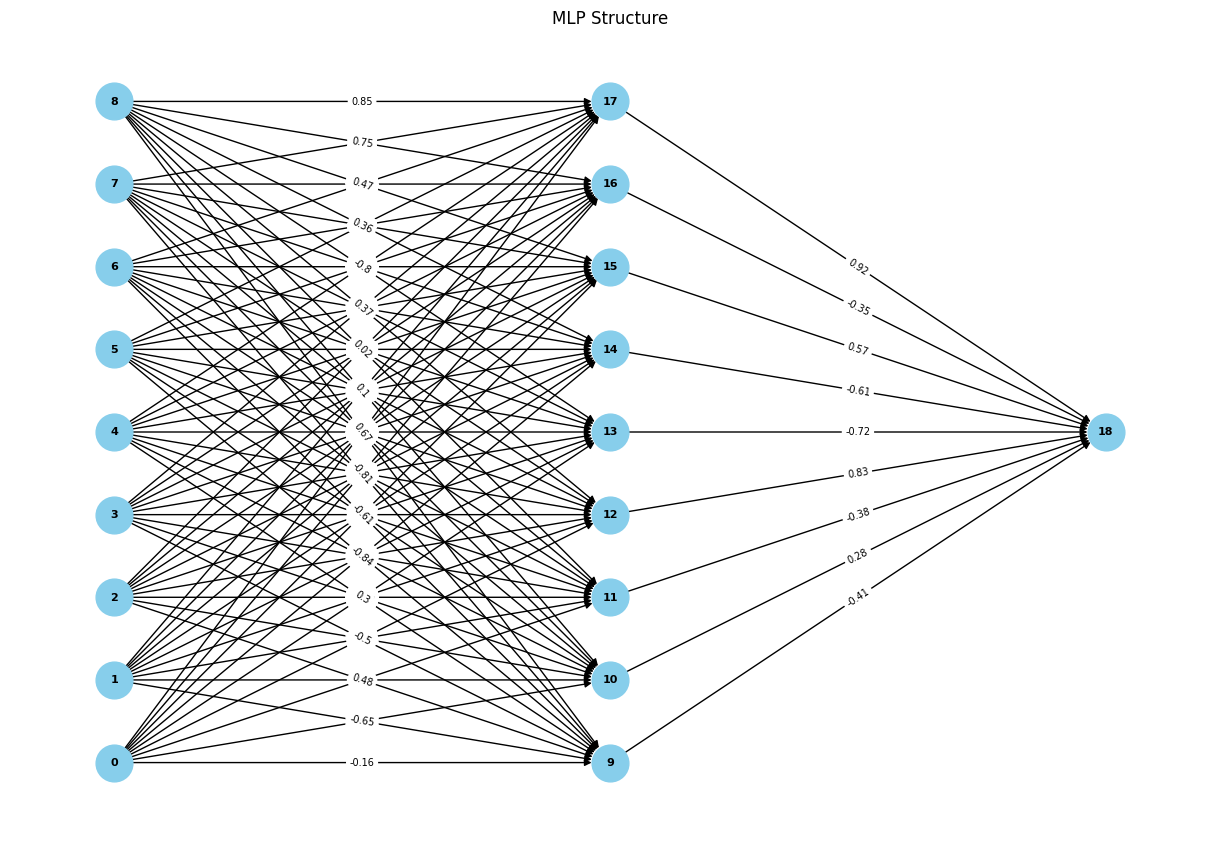

Listing all weights in the network:

Layer 1 to Layer 2:
  Weight from Neuron 0 in Layer 1 to Neuron 0 in Layer 2: -0.1592
  Weight from Neuron 0 in Layer 1 to Neuron 1 in Layer 2: -0.8629
  Weight from Neuron 0 in Layer 1 to Neuron 2 in Layer 2: 0.8220
  Weight from Neuron 0 in Layer 1 to Neuron 3 in Layer 2: 0.0483
  Weight from Neuron 0 in Layer 1 to Neuron 4 in Layer 2: 0.9423
  Weight from Neuron 0 in Layer 1 to Neuron 5 in Layer 2: -0.1094
  Weight from Neuron 0 in Layer 1 to Neuron 6 in Layer 2: -0.1089
  Weight from Neuron 0 in Layer 1 to Neuron 7 in Layer 2: 0.4931
  Weight from Neuron 0 in Layer 1 to Neuron 8 in Layer 2: -0.1951
  Weight from Neuron 1 in Layer 1 to Neuron 0 in Layer 2: -0.6465
  Weight from Neuron 1 in Layer 1 to Neuron 1 in Layer 2: -0.0969
  Weight from Neuron 1 in Layer 1 to Neuron 2 in Layer 2: -0.1807
  Weight from Neuron 1 in Layer 1 to Neuron 3 in Layer 2: -0.6309
  Weight from Neuron 1 in Layer 1 to Neuron 4 in Layer 2: 0.8749
  Weight from Neuron 1 i

In [79]:
layers = (9, 9, 1)  # Especifica 3 camadas: 9 de entrada, 9 ocultas, 1 de saída
mlp = MLP(*layers)

# Plotar a rede
mlp.plot_network()
# Listar os pesos da rede
mlp.list_weights()

Treinando a MLP...
Epoch 1, Train Loss: 0.040622, Test Loss: 0.028004
Epoch 2, Train Loss: 0.029203, Test Loss: 0.029124
Epoch 3, Train Loss: 0.018105, Test Loss: 0.011782
Epoch 4, Train Loss: 0.013051, Test Loss: 0.014632
Epoch 5, Train Loss: 0.012711, Test Loss: 0.012376
Epoch 6, Train Loss: 0.012522, Test Loss: 0.011548
Epoch 7, Train Loss: 0.012523, Test Loss: 0.011658
Epoch 8, Train Loss: 0.012210, Test Loss: 0.011499
Epoch 9, Train Loss: 0.012698, Test Loss: 0.011699
Epoch 10, Train Loss: 0.012324, Test Loss: 0.013788
Epoch 11, Train Loss: 0.012347, Test Loss: 0.011876
Epoch 12, Train Loss: 0.012713, Test Loss: 0.012694
Epoch 13, Train Loss: 0.012482, Test Loss: 0.011819
Epoch 14, Train Loss: 0.013001, Test Loss: 0.017946
Epoch 15, Train Loss: 0.012309, Test Loss: 0.012785
Epoch 16, Train Loss: 0.012209, Test Loss: 0.013175
Epoch 17, Train Loss: 0.013112, Test Loss: 0.012053
Epoch 18, Train Loss: 0.012558, Test Loss: 0.011493
Epoch 19, Train Loss: 0.012685, Test Loss: 0.011435
Ep

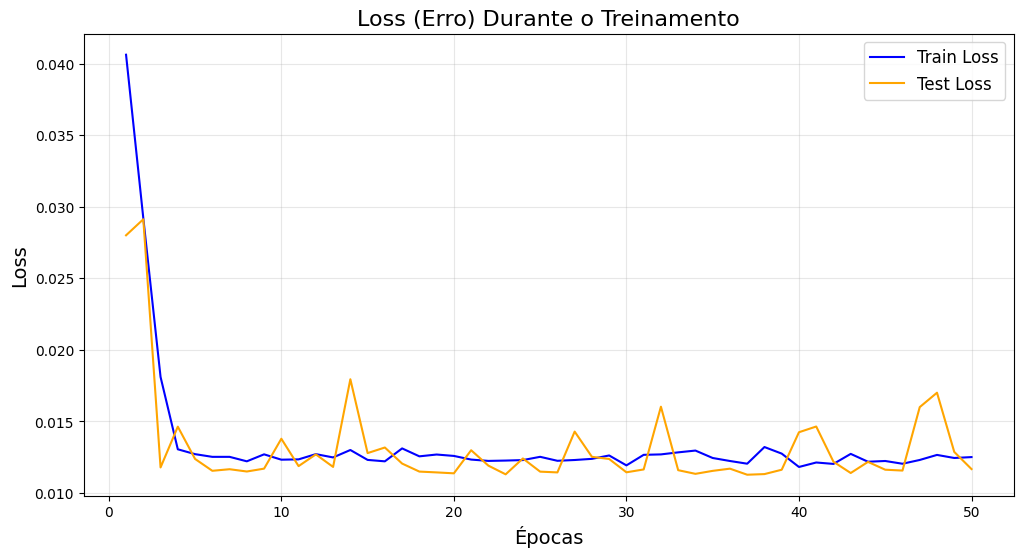

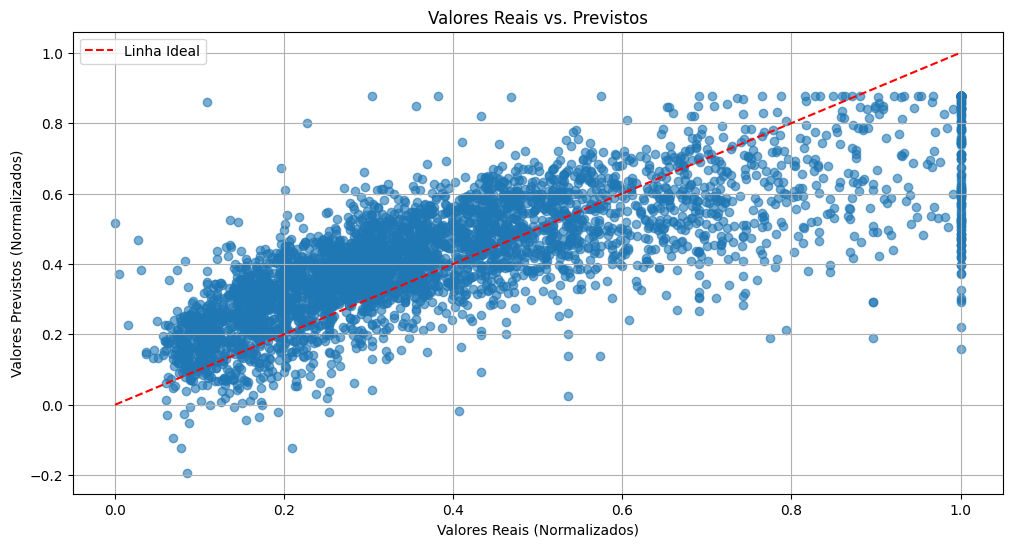

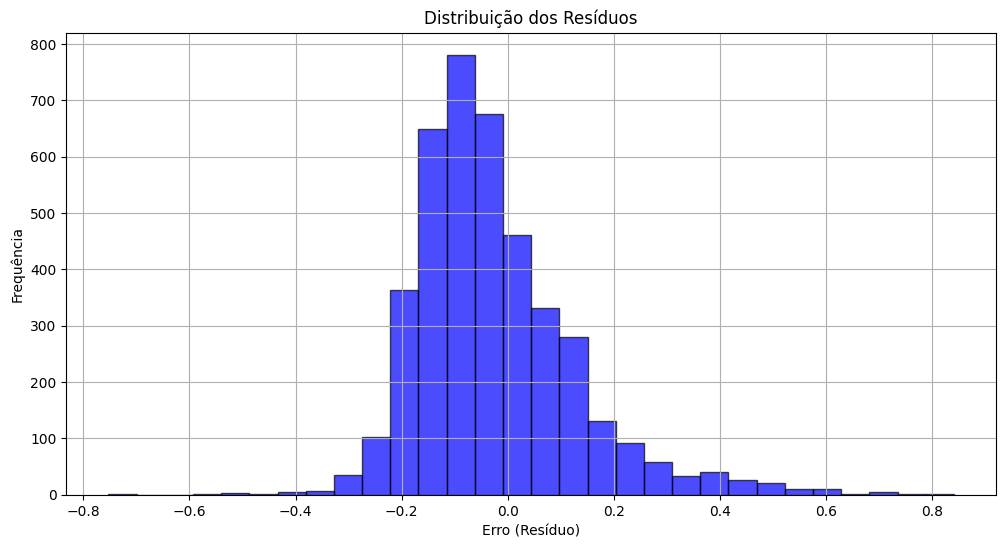

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Carregar o dataset
california_data = fetch_california_housing(as_frame=True)
california_df = california_data.frame

# Separar entradas (features) e saída (target)
X = california_df.drop("MedHouseVal", axis=1).values  # Entradas (features)
y = california_df["MedHouseVal"].values  # Saída (target)

# Normalizar os dados
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)  # Normaliza entre 0 e 1
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()  # Normaliza a saída entre 0 e 1

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Configurar a MLP
mlp = MLP(8, 10, 1, learning_rate=0.01)  # 8 features de entrada, 10 neurônios ocultos, 1 saída

# Treinar a MLP com os dados de treino e monitorar a loss (erro) em treino e teste
train_loss = []
test_loss = [] 

print("Treinando a MLP...")
epochs = 50  # Número de épocas
batch_size = 32  # Tamanho do mini-batch

for epoch in range(epochs):
    total_train_error = 0

    # Embaralhar os dados no início de cada época
    indices = np.arange(len(X_train))
    np.random.shuffle(indices)
    X_train = X_train[indices]
    y_train = y_train[indices]

    # Processar os mini-batches
    for i in range(0, len(X_train), batch_size):
        batch_inputs = X_train[i:i + batch_size]  # Mini-batch de entrada
        batch_outputs = y_train[i:i + batch_size].reshape(-1, 1)  # Mini-batch de saída (como matriz)

        # Propagação para frente e retropropagação
        mlp.forward_propagation(batch_inputs)  # (batch_size, input_size)
        mlp.backward_propagation(batch_outputs)  # (batch_size, output_size)

        # Acumular erro do treinamento
        total_train_error += np.sum((batch_outputs - mlp.outputs[-1]) ** 2) / 2

    # Calcular erro médio no conjunto de treino
    avg_train_error = total_train_error / len(X_train)
    train_loss.append(avg_train_error)

    # Cálculo do erro no conjunto de teste (test loss)
    total_test_error = 0
    for i in range(0, len(X_test), batch_size):
        batch_inputs = X_test[i:i + batch_size]
        batch_outputs = y_test[i:i + batch_size].reshape(-1, 1)
        predictions = mlp.forward_propagation(batch_inputs)
        total_test_error += np.sum((batch_outputs - predictions) ** 2) / 2

    avg_test_error = total_test_error / len(X_test)
    test_loss.append(avg_test_error)  # Armazenar o erro médio de teste

    print(f"Epoch {epoch + 1}, Train Loss: {avg_train_error:.6f}, Test Loss: {avg_test_error:.6f}")

# Testar o modelo diretamente pela classe MLP
predictions, mse, mae, r2 = mlp.test_model(X_test, y_test)

# Imprimir métricas
print("\nMétricas de Desempenho no Teste:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R² Score: {r2:.6f}")

# Plotar os erros do treino e do teste ao longo das épocas
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_loss, label="Train Loss", color='blue')
plt.plot(range(1, epochs + 1), test_loss, label="Test Loss", color='orange')

plt.title("Loss (Erro) Durante o Treinamento", fontsize=16)
plt.xlabel("Épocas", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Plotar valores reais vs previstos
plt.figure(figsize=(12, 6))
plt.scatter(y_test, predictions, alpha=0.6)
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Linha Ideal")
plt.title("Valores Reais vs. Previstos")
plt.xlabel("Valores Reais (Normalizados)")
plt.ylabel("Valores Previstos (Normalizados)")
plt.legend()
plt.grid()
plt.show()

# Plotar distribuições dos erros (resíduos)
residuals = [y_test[i] - predictions[i] for i in range(len(y_test))]
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, alpha=0.7, color="blue", edgecolor="black")
plt.title("Distribuição dos Resíduos")
plt.xlabel("Erro (Resíduo)")
plt.ylabel("Frequência")
plt.grid()
plt.show()

### learning rate de 0.01 para 0.001


Treinando a MLP...
Epoch 1, Train Loss: 0.021375, Test Loss: 0.011839
Epoch 2, Train Loss: 0.011603, Test Loss: 0.012066
Epoch 3, Train Loss: 0.011539, Test Loss: 0.012173
Epoch 4, Train Loss: 0.011477, Test Loss: 0.012230
Epoch 5, Train Loss: 0.011415, Test Loss: 0.011899
Epoch 6, Train Loss: 0.011333, Test Loss: 0.011557
Epoch 7, Train Loss: 0.011369, Test Loss: 0.011771
Epoch 8, Train Loss: 0.011312, Test Loss: 0.011494
Epoch 9, Train Loss: 0.011347, Test Loss: 0.011586
Epoch 10, Train Loss: 0.011408, Test Loss: 0.011808
Epoch 11, Train Loss: 0.011366, Test Loss: 0.011709
Epoch 12, Train Loss: 0.011343, Test Loss: 0.011762
Epoch 13, Train Loss: 0.011270, Test Loss: 0.011494
Epoch 14, Train Loss: 0.011291, Test Loss: 0.011480
Epoch 15, Train Loss: 0.011277, Test Loss: 0.011897
Epoch 16, Train Loss: 0.011270, Test Loss: 0.011519
Epoch 17, Train Loss: 0.011249, Test Loss: 0.011602
Epoch 18, Train Loss: 0.011301, Test Loss: 0.011645
Epoch 19, Train Loss: 0.011247, Test Loss: 0.011441
Ep

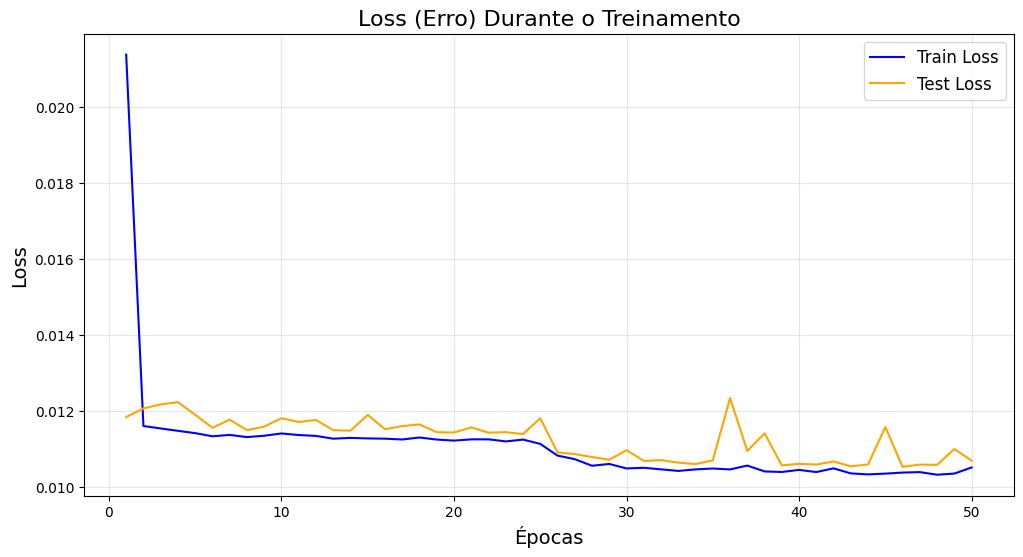

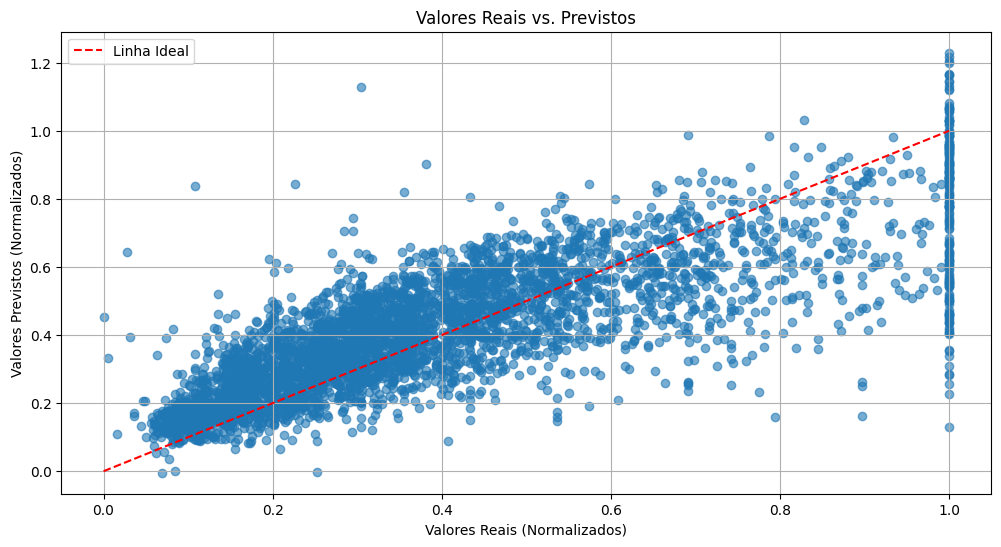

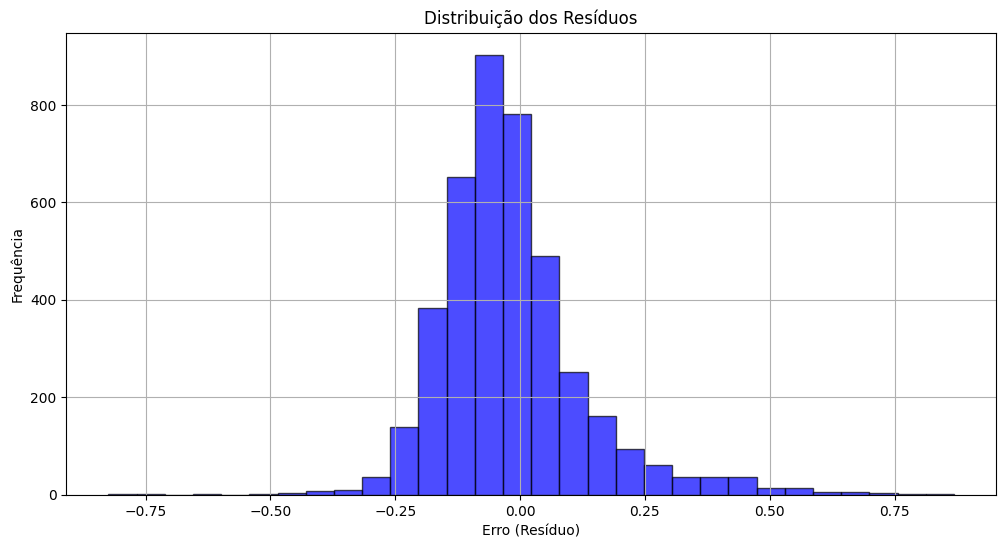

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Carregar o dataset
california_data = fetch_california_housing(as_frame=True)
california_df = california_data.frame

# Separar entradas (features) e saída (target)
X = california_df.drop("MedHouseVal", axis=1).values  # Entradas (features)
y = california_df["MedHouseVal"].values  # Saída (target)

# Normalizar os dados
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)  # Normaliza entre 0 e 1
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()  # Normaliza a saída entre 0 e 1

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Configurar a MLP
mlp = MLP(8, 10, 1, learning_rate=0.001)  # 8 features de entrada, 10 neurônios ocultos, 1 saída

# Treinar a MLP com os dados de treino e monitorar a loss (erro) em treino e teste
train_loss = []
test_loss = [] 

print("Treinando a MLP...")
epochs = 50  # Número de épocas
batch_size = 32  # Tamanho do mini-batch

for epoch in range(epochs):
    total_train_error = 0

    # Embaralhar os dados no início de cada época
    indices = np.arange(len(X_train))
    np.random.shuffle(indices)
    X_train = X_train[indices]
    y_train = y_train[indices]

    # Processar os mini-batches
    for i in range(0, len(X_train), batch_size):
        batch_inputs = X_train[i:i + batch_size]  # Mini-batch de entrada
        batch_outputs = y_train[i:i + batch_size].reshape(-1, 1)  # Mini-batch de saída (como matriz)

        # Propagação para frente e retropropagação
        mlp.forward_propagation(batch_inputs)  # (batch_size, input_size)
        mlp.backward_propagation(batch_outputs)  # (batch_size, output_size)

        # Acumular erro do treinamento
        total_train_error += np.sum((batch_outputs - mlp.outputs[-1]) ** 2) / 2

    # Calcular erro médio no conjunto de treino
    avg_train_error = total_train_error / len(X_train)
    train_loss.append(avg_train_error)

    # Cálculo do erro no conjunto de teste (test loss)
    total_test_error = 0
    for i in range(0, len(X_test), batch_size):
        batch_inputs = X_test[i:i + batch_size]
        batch_outputs = y_test[i:i + batch_size].reshape(-1, 1)
        predictions = mlp.forward_propagation(batch_inputs)
        total_test_error += np.sum((batch_outputs - predictions) ** 2) / 2

    avg_test_error = total_test_error / len(X_test)
    test_loss.append(avg_test_error)  # Armazenar o erro médio de teste

    print(f"Epoch {epoch + 1}, Train Loss: {avg_train_error:.6f}, Test Loss: {avg_test_error:.6f}")

# Testar o modelo diretamente pela classe MLP
predictions, mse, mae, r2 = mlp.test_model(X_test, y_test)

# Imprimir métricas
print("\nMétricas de Desempenho no Teste:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R² Score: {r2:.6f}")

# Plotar os erros do treino e do teste ao longo das épocas
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_loss, label="Train Loss", color='blue')
plt.plot(range(1, epochs + 1), test_loss, label="Test Loss", color='orange')

plt.title("Loss (Erro) Durante o Treinamento", fontsize=16)
plt.xlabel("Épocas", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Plotar valores reais vs previstos
plt.figure(figsize=(12, 6))
plt.scatter(y_test, predictions, alpha=0.6)
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Linha Ideal")
plt.title("Valores Reais vs. Previstos")
plt.xlabel("Valores Reais (Normalizados)")
plt.ylabel("Valores Previstos (Normalizados)")
plt.legend()
plt.grid()
plt.show()

# Plotar distribuições dos erros (resíduos)
residuals = [y_test[i] - predictions[i] for i in range(len(y_test))]
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, alpha=0.7, color="blue", edgecolor="black")
plt.title("Distribuição dos Resíduos")
plt.xlabel("Erro (Resíduo)")
plt.ylabel("Frequência")
plt.grid()
plt.show()

## larning rate 0.01 mas 16 neuronios na camada oculta

Treinando a MLP...
Epoch 1, Train Loss: 0.036985, Test Loss: 0.033210
Epoch 2, Train Loss: 0.029855, Test Loss: 0.028532
Epoch 3, Train Loss: 0.014454, Test Loss: 0.011447
Epoch 4, Train Loss: 0.012008, Test Loss: 0.011307
Epoch 5, Train Loss: 0.011728, Test Loss: 0.011496
Epoch 6, Train Loss: 0.011719, Test Loss: 0.011067
Epoch 7, Train Loss: 0.011445, Test Loss: 0.017225
Epoch 8, Train Loss: 0.011686, Test Loss: 0.011178
Epoch 9, Train Loss: 0.011765, Test Loss: 0.012143
Epoch 10, Train Loss: 0.011607, Test Loss: 0.011312
Epoch 11, Train Loss: 0.011449, Test Loss: 0.011585
Epoch 12, Train Loss: 0.011564, Test Loss: 0.013497
Epoch 13, Train Loss: 0.011849, Test Loss: 0.011123
Epoch 14, Train Loss: 0.011954, Test Loss: 0.010897
Epoch 15, Train Loss: 0.011580, Test Loss: 0.011064
Epoch 16, Train Loss: 0.011656, Test Loss: 0.013582
Epoch 17, Train Loss: 0.011769, Test Loss: 0.010806
Epoch 18, Train Loss: 0.011467, Test Loss: 0.011173
Epoch 19, Train Loss: 0.011417, Test Loss: 0.010781
Ep

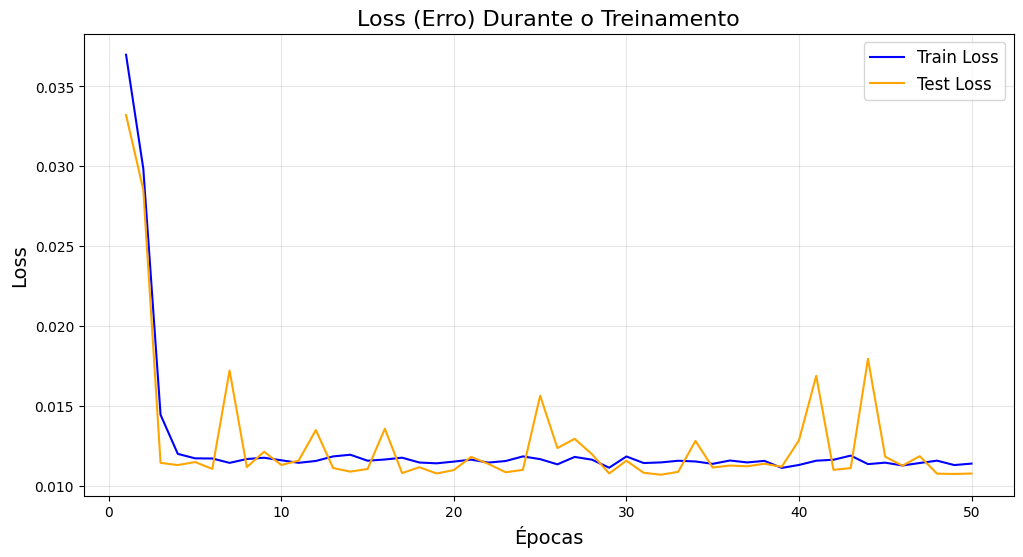

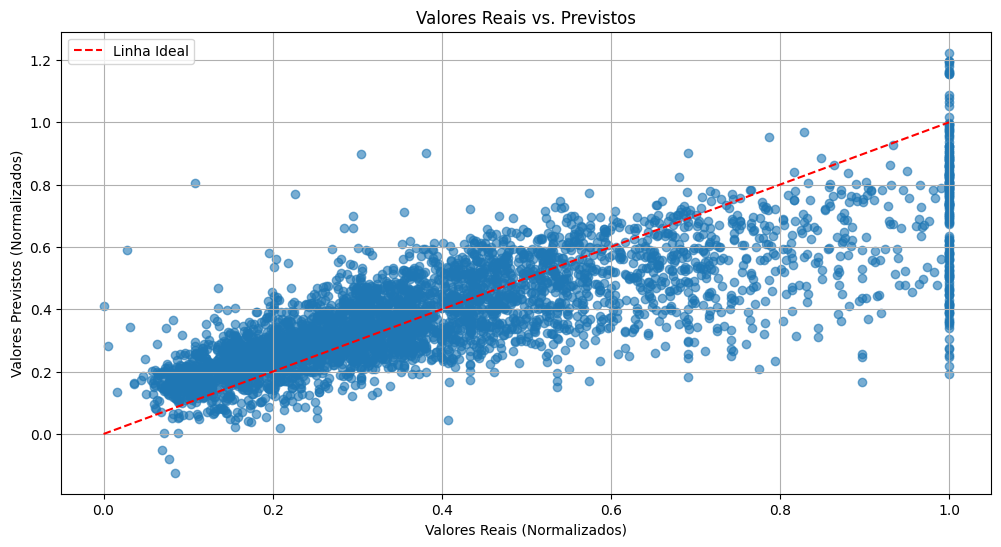

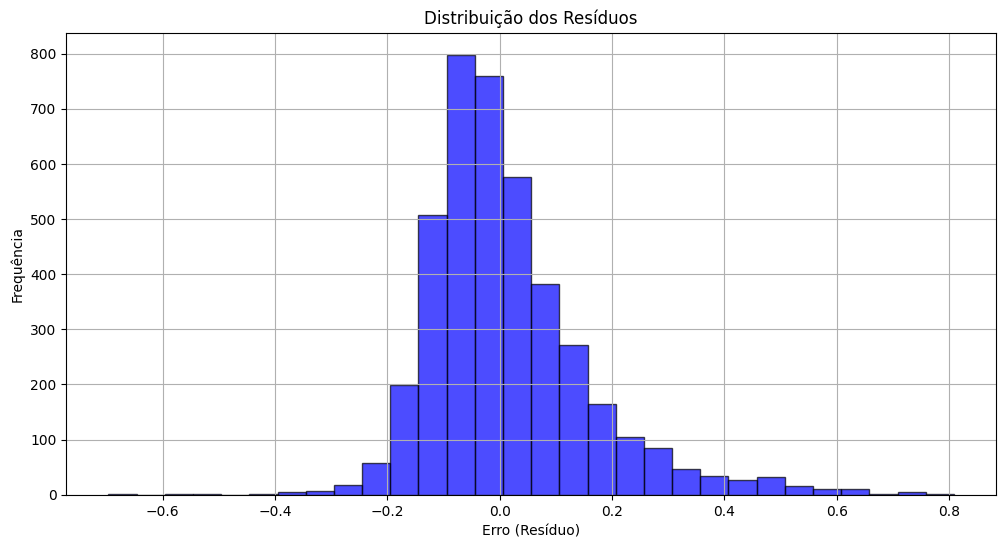

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Carregar o dataset
california_data = fetch_california_housing(as_frame=True)
california_df = california_data.frame

# Separar entradas (features) e saída (target)
X = california_df.drop("MedHouseVal", axis=1).values  # Entradas (features)
y = california_df["MedHouseVal"].values  # Saída (target)

# Normalizar os dados
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)  # Normaliza entre 0 e 1
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()  # Normaliza a saída entre 0 e 1

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Configurar a MLP
mlp = MLP(8, 16, 1, learning_rate=0.01)  # 8 features de entrada, 10 neurônios ocultos, 1 saída

# Treinar a MLP com os dados de treino e monitorar a loss (erro) em treino e teste
train_loss = []
test_loss = [] 

print("Treinando a MLP...")
epochs = 50  # Número de épocas
batch_size = 32  # Tamanho do mini-batch

for epoch in range(epochs):
    total_train_error = 0

    # Embaralhar os dados no início de cada época
    indices = np.arange(len(X_train))
    np.random.shuffle(indices)
    X_train = X_train[indices]
    y_train = y_train[indices]

    # Processar os mini-batches
    for i in range(0, len(X_train), batch_size):
        batch_inputs = X_train[i:i + batch_size]  # Mini-batch de entrada
        batch_outputs = y_train[i:i + batch_size].reshape(-1, 1)  # Mini-batch de saída (como matriz)

        # Propagação para frente e retropropagação
        mlp.forward_propagation(batch_inputs)  # (batch_size, input_size)
        mlp.backward_propagation(batch_outputs)  # (batch_size, output_size)

        # Acumular erro do treinamento
        total_train_error += np.sum((batch_outputs - mlp.outputs[-1]) ** 2) / 2

    # Calcular erro médio no conjunto de treino
    avg_train_error = total_train_error / len(X_train)
    train_loss.append(avg_train_error)

    # Cálculo do erro no conjunto de teste (test loss)
    total_test_error = 0
    for i in range(0, len(X_test), batch_size):
        batch_inputs = X_test[i:i + batch_size]
        batch_outputs = y_test[i:i + batch_size].reshape(-1, 1)
        predictions = mlp.forward_propagation(batch_inputs)
        total_test_error += np.sum((batch_outputs - predictions) ** 2) / 2

    avg_test_error = total_test_error / len(X_test)
    test_loss.append(avg_test_error)  # Armazenar o erro médio de teste

    print(f"Epoch {epoch + 1}, Train Loss: {avg_train_error:.6f}, Test Loss: {avg_test_error:.6f}")

# Testar o modelo diretamente pela classe MLP
predictions, mse, mae, r2 = mlp.test_model(X_test, y_test)

# Imprimir métricas
print("\nMétricas de Desempenho no Teste:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R² Score: {r2:.6f}")

# Plotar os erros do treino e do teste ao longo das épocas
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_loss, label="Train Loss", color='blue')
plt.plot(range(1, epochs + 1), test_loss, label="Test Loss", color='orange')

plt.title("Loss (Erro) Durante o Treinamento", fontsize=16)
plt.xlabel("Épocas", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Plotar valores reais vs previstos
plt.figure(figsize=(12, 6))
plt.scatter(y_test, predictions, alpha=0.6)
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Linha Ideal")
plt.title("Valores Reais vs. Previstos")
plt.xlabel("Valores Reais (Normalizados)")
plt.ylabel("Valores Previstos (Normalizados)")
plt.legend()
plt.grid()
plt.show()

# Plotar distribuições dos erros (resíduos)
residuals = [y_test[i] - predictions[i] for i in range(len(y_test))]
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, alpha=0.7, color="blue", edgecolor="black")
plt.title("Distribuição dos Resíduos")
plt.xlabel("Erro (Resíduo)")
plt.ylabel("Frequência")
plt.grid()
plt.show()

## learning rate 0.001 16 neuronios camada oculta

Treinando a MLP...
Epoch 1, Train Loss: 0.020697, Test Loss: 0.012150
Epoch 2, Train Loss: 0.011474, Test Loss: 0.011561
Epoch 3, Train Loss: 0.011019, Test Loss: 0.010997
Epoch 4, Train Loss: 0.011018, Test Loss: 0.012901
Epoch 5, Train Loss: 0.010855, Test Loss: 0.011014
Epoch 6, Train Loss: 0.010717, Test Loss: 0.011318
Epoch 7, Train Loss: 0.010655, Test Loss: 0.010722
Epoch 8, Train Loss: 0.010640, Test Loss: 0.011021
Epoch 9, Train Loss: 0.010611, Test Loss: 0.010718
Epoch 10, Train Loss: 0.010602, Test Loss: 0.010804
Epoch 11, Train Loss: 0.010645, Test Loss: 0.010612
Epoch 12, Train Loss: 0.010634, Test Loss: 0.011327
Epoch 13, Train Loss: 0.010591, Test Loss: 0.010607
Epoch 14, Train Loss: 0.010518, Test Loss: 0.010673
Epoch 15, Train Loss: 0.010530, Test Loss: 0.011264
Epoch 16, Train Loss: 0.010390, Test Loss: 0.010542
Epoch 17, Train Loss: 0.010484, Test Loss: 0.010541
Epoch 18, Train Loss: 0.010482, Test Loss: 0.010564
Epoch 19, Train Loss: 0.010423, Test Loss: 0.012477
Ep

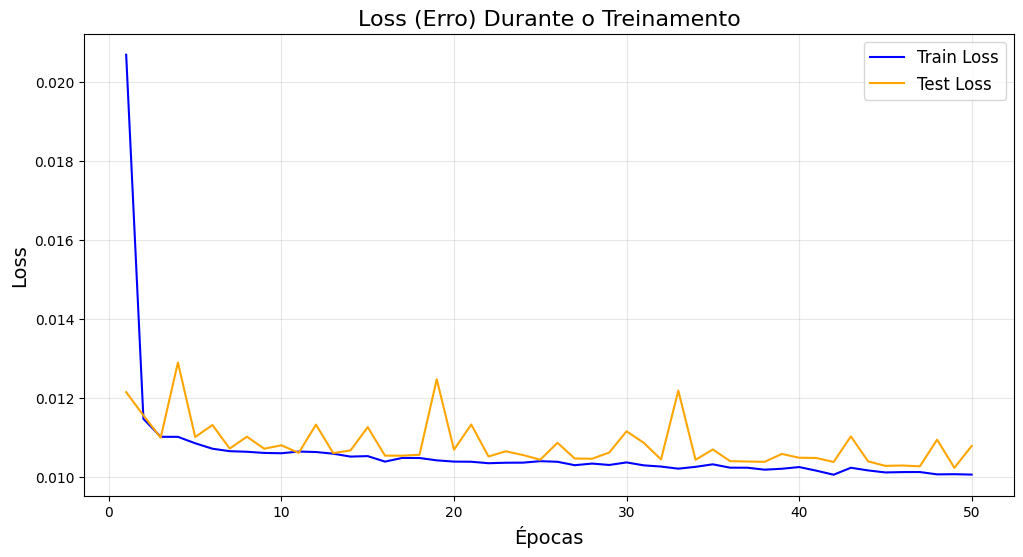

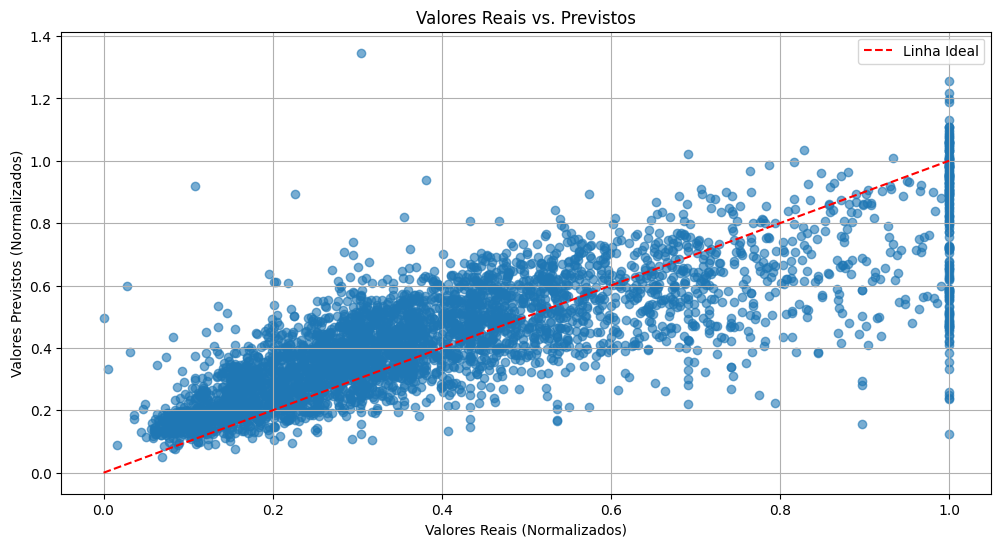

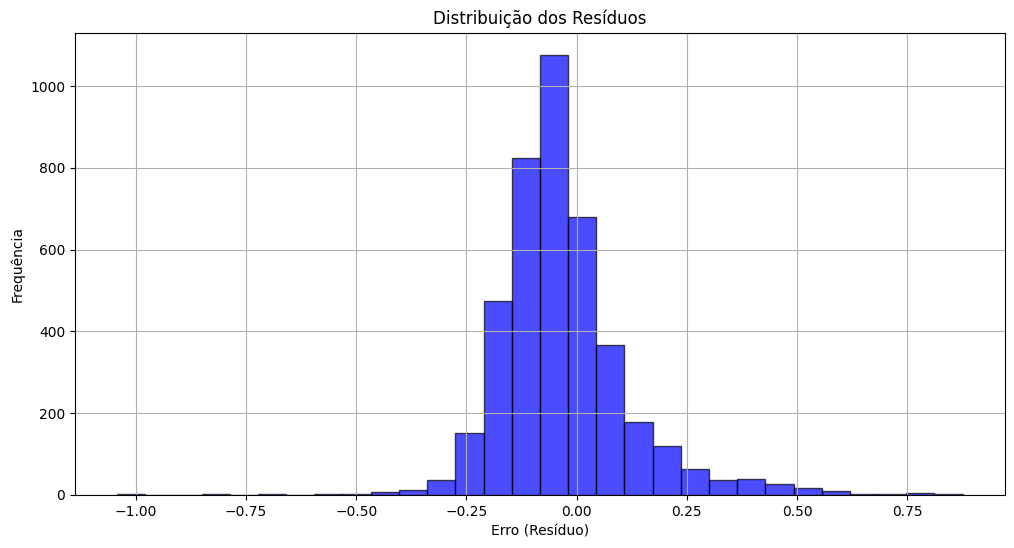

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Carregar o dataset
california_data = fetch_california_housing(as_frame=True)
california_df = california_data.frame

# Separar entradas (features) e saída (target)
X = california_df.drop("MedHouseVal", axis=1).values  # Entradas (features)
y = california_df["MedHouseVal"].values  # Saída (target)

# Normalizar os dados
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)  # Normaliza entre 0 e 1
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()  # Normaliza a saída entre 0 e 1

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Configurar a MLP
mlp = MLP(8, 16, 1, learning_rate=0.001)  # 8 features de entrada, 10 neurônios ocultos, 1 saída

# Treinar a MLP com os dados de treino e monitorar a loss (erro) em treino e teste
train_loss = []
test_loss = [] 

print("Treinando a MLP...")
epochs = 50  # Número de épocas
batch_size = 32  # Tamanho do mini-batch

for epoch in range(epochs):
    total_train_error = 0

    # Embaralhar os dados no início de cada época
    indices = np.arange(len(X_train))
    np.random.shuffle(indices)
    X_train = X_train[indices]
    y_train = y_train[indices]

    # Processar os mini-batches
    for i in range(0, len(X_train), batch_size):
        batch_inputs = X_train[i:i + batch_size]  # Mini-batch de entrada
        batch_outputs = y_train[i:i + batch_size].reshape(-1, 1)  # Mini-batch de saída (como matriz)

        # Propagação para frente e retropropagação
        mlp.forward_propagation(batch_inputs)  # (batch_size, input_size)
        mlp.backward_propagation(batch_outputs)  # (batch_size, output_size)

        # Acumular erro do treinamento
        total_train_error += np.sum((batch_outputs - mlp.outputs[-1]) ** 2) / 2

    # Calcular erro médio no conjunto de treino
    avg_train_error = total_train_error / len(X_train)
    train_loss.append(avg_train_error)

    # Cálculo do erro no conjunto de teste (test loss)
    total_test_error = 0
    for i in range(0, len(X_test), batch_size):
        batch_inputs = X_test[i:i + batch_size]
        batch_outputs = y_test[i:i + batch_size].reshape(-1, 1)
        predictions = mlp.forward_propagation(batch_inputs)
        total_test_error += np.sum((batch_outputs - predictions) ** 2) / 2

    avg_test_error = total_test_error / len(X_test)
    test_loss.append(avg_test_error)  # Armazenar o erro médio de teste

    print(f"Epoch {epoch + 1}, Train Loss: {avg_train_error:.6f}, Test Loss: {avg_test_error:.6f}")

# Testar o modelo diretamente pela classe MLP
predictions, mse, mae, r2 = mlp.test_model(X_test, y_test)

# Imprimir métricas
print("\nMétricas de Desempenho no Teste:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R² Score: {r2:.6f}")

# Plotar os erros do treino e do teste ao longo das épocas
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_loss, label="Train Loss", color='blue')
plt.plot(range(1, epochs + 1), test_loss, label="Test Loss", color='orange')

plt.title("Loss (Erro) Durante o Treinamento", fontsize=16)
plt.xlabel("Épocas", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Plotar valores reais vs previstos
plt.figure(figsize=(12, 6))
plt.scatter(y_test, predictions, alpha=0.6)
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Linha Ideal")
plt.title("Valores Reais vs. Previstos")
plt.xlabel("Valores Reais (Normalizados)")
plt.ylabel("Valores Previstos (Normalizados)")
plt.legend()
plt.grid()
plt.show()

# Plotar distribuições dos erros (resíduos)
residuals = [y_test[i] - predictions[i] for i in range(len(y_test))]
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, alpha=0.7, color="blue", edgecolor="black")
plt.title("Distribuição dos Resíduos")
plt.xlabel("Erro (Resíduo)")
plt.ylabel("Frequência")
plt.grid()
plt.show()

## learning rate 0.01 32 neuronios camada oculta

Treinando a MLP...
Epoch 1, Train Loss: 0.089315, Test Loss: 0.012239
Epoch 2, Train Loss: 0.011971, Test Loss: 0.012321
Epoch 3, Train Loss: 0.012487, Test Loss: 0.011751
Epoch 4, Train Loss: 0.011912, Test Loss: 0.011107
Epoch 5, Train Loss: 0.011939, Test Loss: 0.010990
Epoch 6, Train Loss: 0.012247, Test Loss: 0.011645
Epoch 7, Train Loss: 0.012123, Test Loss: 0.011725
Epoch 8, Train Loss: 0.012065, Test Loss: 0.011254
Epoch 9, Train Loss: 0.012300, Test Loss: 0.015270
Epoch 10, Train Loss: 0.012072, Test Loss: 0.011010
Epoch 11, Train Loss: 0.012073, Test Loss: 0.011075
Epoch 12, Train Loss: 0.011988, Test Loss: 0.011338
Epoch 13, Train Loss: 0.011809, Test Loss: 0.012355
Epoch 14, Train Loss: 0.011902, Test Loss: 0.012008
Epoch 15, Train Loss: 0.012421, Test Loss: 0.011954
Epoch 16, Train Loss: 0.012022, Test Loss: 0.012194
Epoch 17, Train Loss: 0.011760, Test Loss: 0.012435
Epoch 18, Train Loss: 0.012300, Test Loss: 0.011163
Epoch 19, Train Loss: 0.011986, Test Loss: 0.012414
Ep

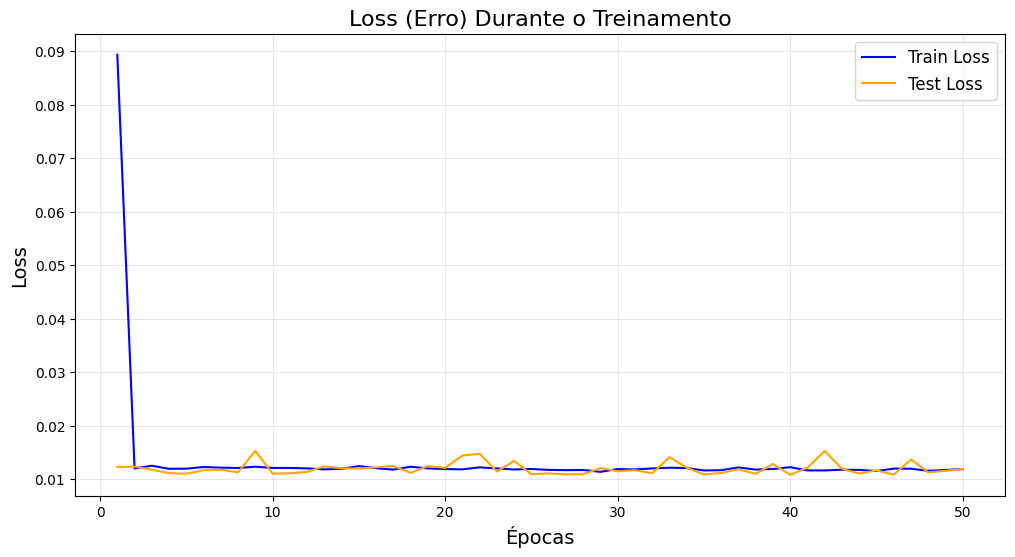

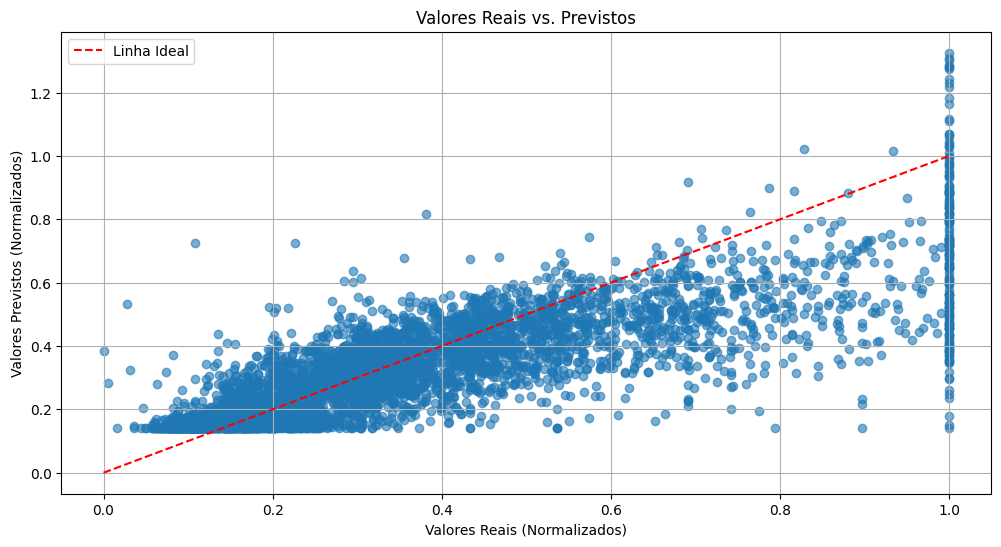

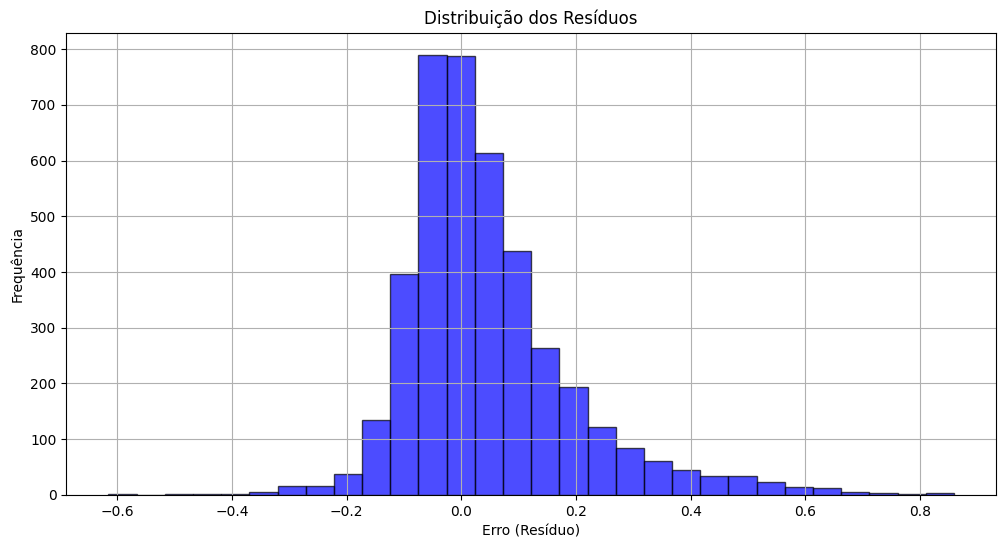

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Carregar o dataset
california_data = fetch_california_housing(as_frame=True)
california_df = california_data.frame

# Separar entradas (features) e saída (target)
X = california_df.drop("MedHouseVal", axis=1).values  # Entradas (features)
y = california_df["MedHouseVal"].values  # Saída (target)

# Normalizar os dados
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)  # Normaliza entre 0 e 1
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()  # Normaliza a saída entre 0 e 1

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Configurar a MLP
mlp = MLP(8, 32, 1, learning_rate=0.01)  # 8 features de entrada, 10 neurônios ocultos, 1 saída

# Treinar a MLP com os dados de treino e monitorar a loss (erro) em treino e teste
train_loss = []
test_loss = [] 

print("Treinando a MLP...")
epochs = 50  # Número de épocas
batch_size = 32  # Tamanho do mini-batch

for epoch in range(epochs):
    total_train_error = 0

    # Embaralhar os dados no início de cada época
    indices = np.arange(len(X_train))
    np.random.shuffle(indices)
    X_train = X_train[indices]
    y_train = y_train[indices]

    # Processar os mini-batches
    for i in range(0, len(X_train), batch_size):
        batch_inputs = X_train[i:i + batch_size]  # Mini-batch de entrada
        batch_outputs = y_train[i:i + batch_size].reshape(-1, 1)  # Mini-batch de saída (como matriz)

        # Propagação para frente e retropropagação
        mlp.forward_propagation(batch_inputs)  # (batch_size, input_size)
        mlp.backward_propagation(batch_outputs)  # (batch_size, output_size)

        # Acumular erro do treinamento
        total_train_error += np.sum((batch_outputs - mlp.outputs[-1]) ** 2) / 2

    # Calcular erro médio no conjunto de treino
    avg_train_error = total_train_error / len(X_train)
    train_loss.append(avg_train_error)

    # Cálculo do erro no conjunto de teste (test loss)
    total_test_error = 0
    for i in range(0, len(X_test), batch_size):
        batch_inputs = X_test[i:i + batch_size]
        batch_outputs = y_test[i:i + batch_size].reshape(-1, 1)
        predictions = mlp.forward_propagation(batch_inputs)
        total_test_error += np.sum((batch_outputs - predictions) ** 2) / 2

    avg_test_error = total_test_error / len(X_test)
    test_loss.append(avg_test_error)  # Armazenar o erro médio de teste

    print(f"Epoch {epoch + 1}, Train Loss: {avg_train_error:.6f}, Test Loss: {avg_test_error:.6f}")

# Testar o modelo diretamente pela classe MLP
predictions, mse, mae, r2 = mlp.test_model(X_test, y_test)

# Imprimir métricas
print("\nMétricas de Desempenho no Teste:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R² Score: {r2:.6f}")

# Plotar os erros do treino e do teste ao longo das épocas
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_loss, label="Train Loss", color='blue')
plt.plot(range(1, epochs + 1), test_loss, label="Test Loss", color='orange')

plt.title("Loss (Erro) Durante o Treinamento", fontsize=16)
plt.xlabel("Épocas", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Plotar valores reais vs previstos
plt.figure(figsize=(12, 6))
plt.scatter(y_test, predictions, alpha=0.6)
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Linha Ideal")
plt.title("Valores Reais vs. Previstos")
plt.xlabel("Valores Reais (Normalizados)")
plt.ylabel("Valores Previstos (Normalizados)")
plt.legend()
plt.grid()
plt.show()

# Plotar distribuições dos erros (resíduos)
residuals = [y_test[i] - predictions[i] for i in range(len(y_test))]
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, alpha=0.7, color="blue", edgecolor="black")
plt.title("Distribuição dos Resíduos")
plt.xlabel("Erro (Resíduo)")
plt.ylabel("Frequência")
plt.grid()
plt.show()

## learning rate 0.001 32 neuronios

Treinando a MLP...
Epoch 1, Train Loss: 0.025406, Test Loss: 0.011672
Epoch 2, Train Loss: 0.012001, Test Loss: 0.011809
Epoch 3, Train Loss: 0.011608, Test Loss: 0.011584
Epoch 4, Train Loss: 0.011712, Test Loss: 0.011217
Epoch 5, Train Loss: 0.011388, Test Loss: 0.010969
Epoch 6, Train Loss: 0.011241, Test Loss: 0.011525
Epoch 7, Train Loss: 0.011186, Test Loss: 0.011870
Epoch 8, Train Loss: 0.011172, Test Loss: 0.011435
Epoch 9, Train Loss: 0.011117, Test Loss: 0.010886
Epoch 10, Train Loss: 0.011024, Test Loss: 0.010883
Epoch 11, Train Loss: 0.011045, Test Loss: 0.010944
Epoch 12, Train Loss: 0.010789, Test Loss: 0.011094
Epoch 13, Train Loss: 0.010706, Test Loss: 0.011391
Epoch 14, Train Loss: 0.010822, Test Loss: 0.010903
Epoch 15, Train Loss: 0.010648, Test Loss: 0.010733
Epoch 16, Train Loss: 0.010570, Test Loss: 0.010710
Epoch 17, Train Loss: 0.010712, Test Loss: 0.011284
Epoch 18, Train Loss: 0.010627, Test Loss: 0.011193
Epoch 19, Train Loss: 0.010372, Test Loss: 0.010671
Ep

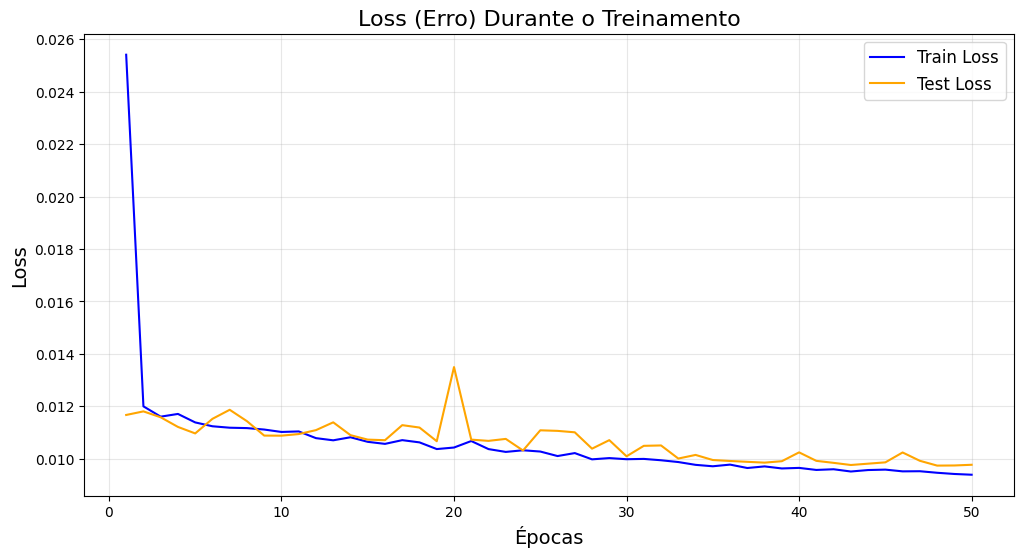

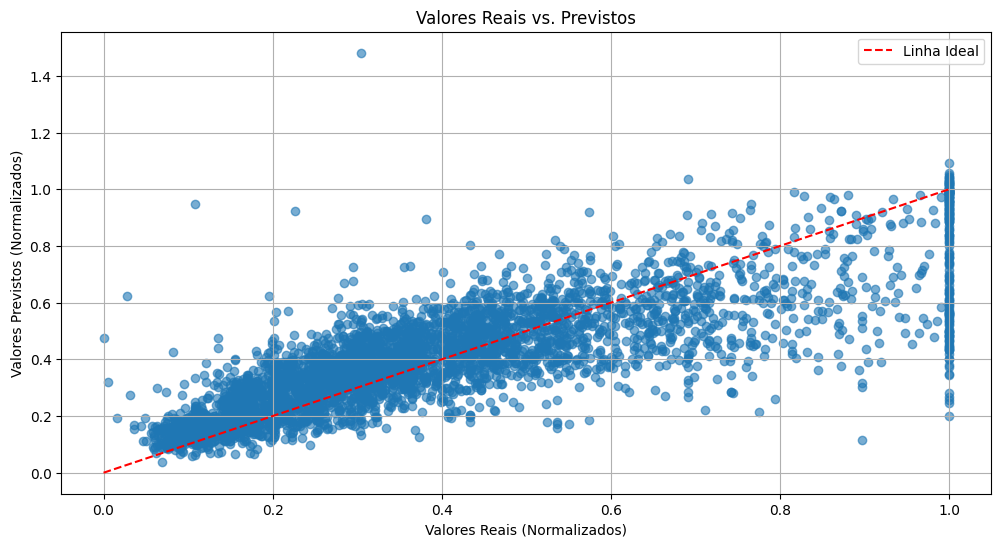

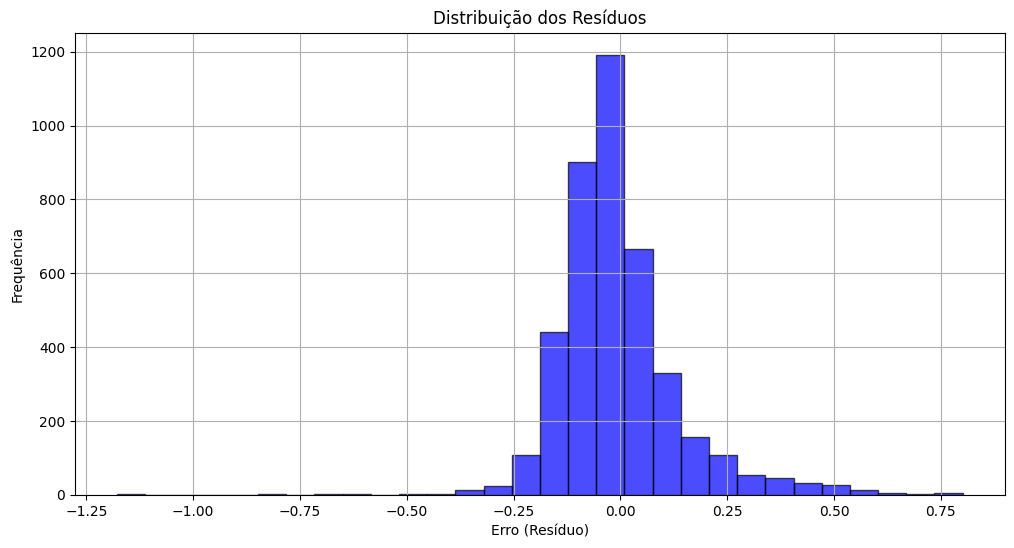

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Carregar o dataset
california_data = fetch_california_housing(as_frame=True)
california_df = california_data.frame

# Separar entradas (features) e saída (target)
X = california_df.drop("MedHouseVal", axis=1).values  # Entradas (features)
y = california_df["MedHouseVal"].values  # Saída (target)

# Normalizar os dados
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)  # Normaliza entre 0 e 1
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()  # Normaliza a saída entre 0 e 1

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Configurar a MLP
mlp = MLP(8, 32, 1, learning_rate=0.001)  # 8 features de entrada, 10 neurônios ocultos, 1 saída

# Treinar a MLP com os dados de treino e monitorar a loss (erro) em treino e teste
train_loss = []
test_loss = [] 

print("Treinando a MLP...")
epochs = 50  # Número de épocas
batch_size = 32  # Tamanho do mini-batch

for epoch in range(epochs):
    total_train_error = 0

    # Embaralhar os dados no início de cada época
    indices = np.arange(len(X_train))
    np.random.shuffle(indices)
    X_train = X_train[indices]
    y_train = y_train[indices]

    # Processar os mini-batches
    for i in range(0, len(X_train), batch_size):
        batch_inputs = X_train[i:i + batch_size]  # Mini-batch de entrada
        batch_outputs = y_train[i:i + batch_size].reshape(-1, 1)  # Mini-batch de saída (como matriz)

        # Propagação para frente e retropropagação
        mlp.forward_propagation(batch_inputs)  # (batch_size, input_size)
        mlp.backward_propagation(batch_outputs)  # (batch_size, output_size)

        # Acumular erro do treinamento
        total_train_error += np.sum((batch_outputs - mlp.outputs[-1]) ** 2) / 2

    # Calcular erro médio no conjunto de treino
    avg_train_error = total_train_error / len(X_train)
    train_loss.append(avg_train_error)

    # Cálculo do erro no conjunto de teste (test loss)
    total_test_error = 0
    for i in range(0, len(X_test), batch_size):
        batch_inputs = X_test[i:i + batch_size]
        batch_outputs = y_test[i:i + batch_size].reshape(-1, 1)
        predictions = mlp.forward_propagation(batch_inputs)
        total_test_error += np.sum((batch_outputs - predictions) ** 2) / 2

    avg_test_error = total_test_error / len(X_test)
    test_loss.append(avg_test_error)  # Armazenar o erro médio de teste

    print(f"Epoch {epoch + 1}, Train Loss: {avg_train_error:.6f}, Test Loss: {avg_test_error:.6f}")

# Testar o modelo diretamente pela classe MLP
predictions, mse, mae, r2 = mlp.test_model(X_test, y_test)

# Imprimir métricas
print("\nMétricas de Desempenho no Teste:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R² Score: {r2:.6f}")

# Plotar os erros do treino e do teste ao longo das épocas
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_loss, label="Train Loss", color='blue')
plt.plot(range(1, epochs + 1), test_loss, label="Test Loss", color='orange')

plt.title("Loss (Erro) Durante o Treinamento", fontsize=16)
plt.xlabel("Épocas", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Plotar valores reais vs previstos
plt.figure(figsize=(12, 6))
plt.scatter(y_test, predictions, alpha=0.6)
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Linha Ideal")
plt.title("Valores Reais vs. Previstos")
plt.xlabel("Valores Reais (Normalizados)")
plt.ylabel("Valores Previstos (Normalizados)")
plt.legend()
plt.grid()
plt.show()

# Plotar distribuições dos erros (resíduos)
residuals = [y_test[i] - predictions[i] for i in range(len(y_test))]
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, alpha=0.7, color="blue", edgecolor="black")
plt.title("Distribuição dos Resíduos")
plt.xlabel("Erro (Resíduo)")
plt.ylabel("Frequência")
plt.grid()
plt.show()

## learning rate 0.01 64 neuronios

Treinando a MLP...
Epoch 1, Train Loss: 2.898780, Test Loss: 0.035255
Epoch 2, Train Loss: 0.024639, Test Loss: 0.011900
Epoch 3, Train Loss: 0.013240, Test Loss: 0.012546
Epoch 4, Train Loss: 0.012866, Test Loss: 0.011621
Epoch 5, Train Loss: 0.013189, Test Loss: 0.011732
Epoch 6, Train Loss: 0.013290, Test Loss: 0.011904
Epoch 7, Train Loss: 0.013446, Test Loss: 0.014288
Epoch 8, Train Loss: 0.012541, Test Loss: 0.011469
Epoch 9, Train Loss: 0.012234, Test Loss: 0.012356
Epoch 10, Train Loss: 0.012863, Test Loss: 0.011560
Epoch 11, Train Loss: 0.012914, Test Loss: 0.015229
Epoch 12, Train Loss: 0.013083, Test Loss: 0.012518
Epoch 13, Train Loss: 0.012825, Test Loss: 0.013192
Epoch 14, Train Loss: 0.012698, Test Loss: 0.013782
Epoch 15, Train Loss: 0.012862, Test Loss: 0.011732
Epoch 16, Train Loss: 0.012868, Test Loss: 0.011563
Epoch 17, Train Loss: 0.012819, Test Loss: 0.011463
Epoch 18, Train Loss: 0.012513, Test Loss: 0.015322
Epoch 19, Train Loss: 0.012473, Test Loss: 0.012548
Ep

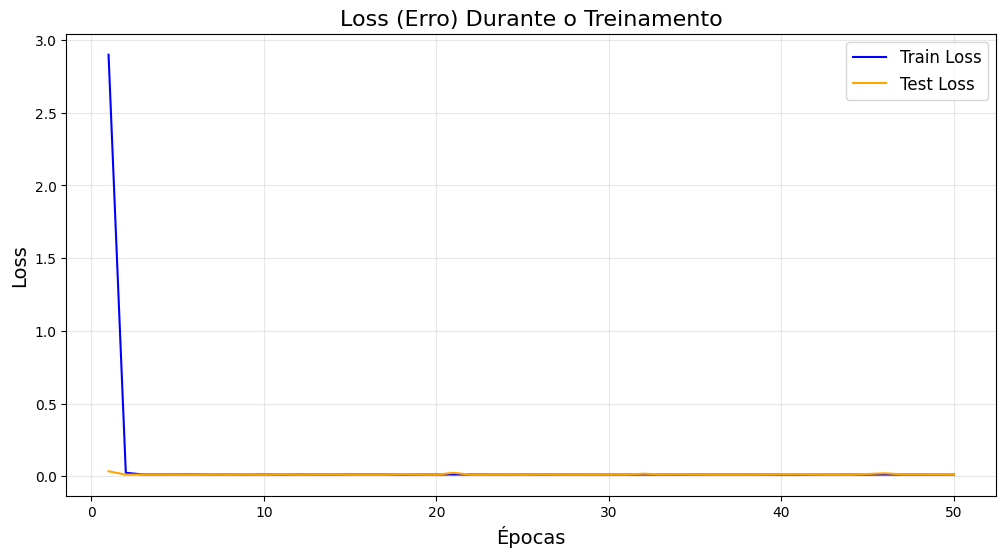

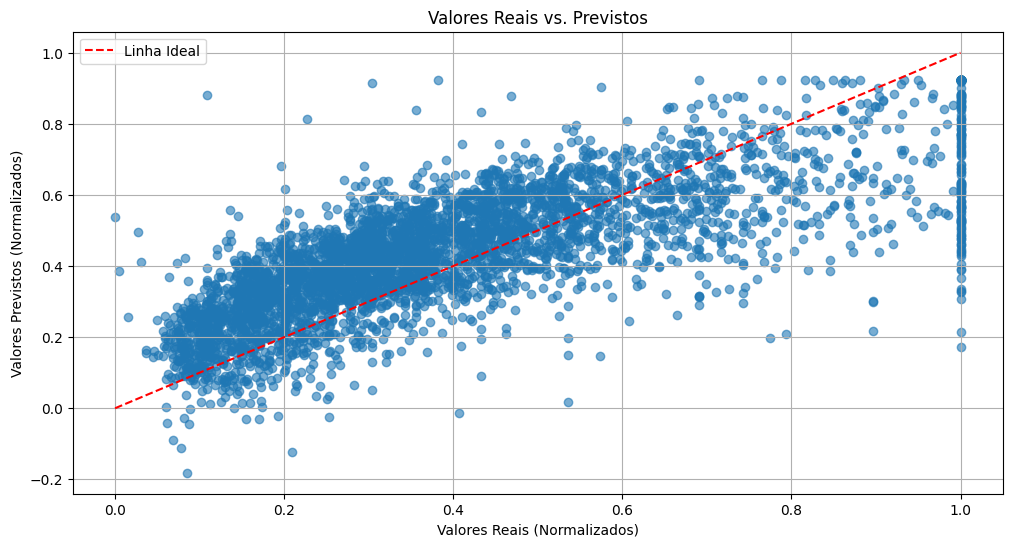

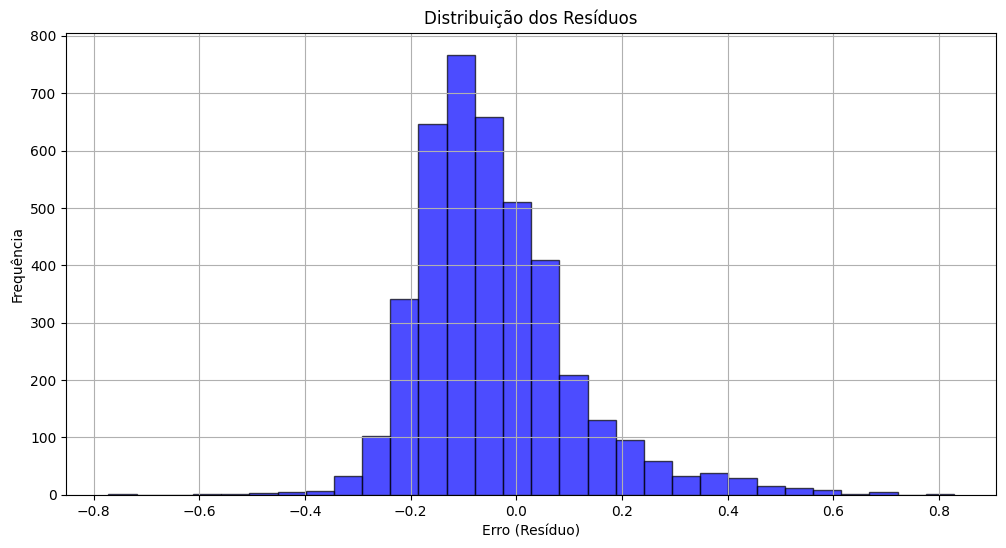

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Carregar o dataset
california_data = fetch_california_housing(as_frame=True)
california_df = california_data.frame

# Separar entradas (features) e saída (target)
X = california_df.drop("MedHouseVal", axis=1).values  # Entradas (features)
y = california_df["MedHouseVal"].values  # Saída (target)

# Normalizar os dados
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)  # Normaliza entre 0 e 1
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()  # Normaliza a saída entre 0 e 1

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Configurar a MLP
mlp = MLP(8, 64, 1, learning_rate=0.01)  # 8 features de entrada, 10 neurônios ocultos, 1 saída

# Treinar a MLP com os dados de treino e monitorar a loss (erro) em treino e teste
train_loss = []
test_loss = [] 

print("Treinando a MLP...")
epochs = 50  # Número de épocas
batch_size = 32  # Tamanho do mini-batch

for epoch in range(epochs):
    total_train_error = 0

    # Embaralhar os dados no início de cada época
    indices = np.arange(len(X_train))
    np.random.shuffle(indices)
    X_train = X_train[indices]
    y_train = y_train[indices]

    # Processar os mini-batches
    for i in range(0, len(X_train), batch_size):
        batch_inputs = X_train[i:i + batch_size]  # Mini-batch de entrada
        batch_outputs = y_train[i:i + batch_size].reshape(-1, 1)  # Mini-batch de saída (como matriz)

        # Propagação para frente e retropropagação
        mlp.forward_propagation(batch_inputs)  # (batch_size, input_size)
        mlp.backward_propagation(batch_outputs)  # (batch_size, output_size)

        # Acumular erro do treinamento
        total_train_error += np.sum((batch_outputs - mlp.outputs[-1]) ** 2) / 2

    # Calcular erro médio no conjunto de treino
    avg_train_error = total_train_error / len(X_train)
    train_loss.append(avg_train_error)

    # Cálculo do erro no conjunto de teste (test loss)
    total_test_error = 0
    for i in range(0, len(X_test), batch_size):
        batch_inputs = X_test[i:i + batch_size]
        batch_outputs = y_test[i:i + batch_size].reshape(-1, 1)
        predictions = mlp.forward_propagation(batch_inputs)
        total_test_error += np.sum((batch_outputs - predictions) ** 2) / 2

    avg_test_error = total_test_error / len(X_test)
    test_loss.append(avg_test_error)  # Armazenar o erro médio de teste

    print(f"Epoch {epoch + 1}, Train Loss: {avg_train_error:.6f}, Test Loss: {avg_test_error:.6f}")

# Testar o modelo diretamente pela classe MLP
predictions, mse, mae, r2 = mlp.test_model(X_test, y_test)

# Imprimir métricas
print("\nMétricas de Desempenho no Teste:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R² Score: {r2:.6f}")

# Plotar os erros do treino e do teste ao longo das épocas
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_loss, label="Train Loss", color='blue')
plt.plot(range(1, epochs + 1), test_loss, label="Test Loss", color='orange')

plt.title("Loss (Erro) Durante o Treinamento", fontsize=16)
plt.xlabel("Épocas", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Plotar valores reais vs previstos
plt.figure(figsize=(12, 6))
plt.scatter(y_test, predictions, alpha=0.6)
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Linha Ideal")
plt.title("Valores Reais vs. Previstos")
plt.xlabel("Valores Reais (Normalizados)")
plt.ylabel("Valores Previstos (Normalizados)")
plt.legend()
plt.grid()
plt.show()

# Plotar distribuições dos erros (resíduos)
residuals = [y_test[i] - predictions[i] for i in range(len(y_test))]
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, alpha=0.7, color="blue", edgecolor="black")
plt.title("Distribuição dos Resíduos")
plt.xlabel("Erro (Resíduo)")
plt.ylabel("Frequência")
plt.grid()
plt.show()

## learning rate 0.001 64 neuronios

Treinando a MLP...
Epoch 1, Train Loss: 0.088208, Test Loss: 0.011889
Epoch 2, Train Loss: 0.011316, Test Loss: 0.011261
Epoch 3, Train Loss: 0.010817, Test Loss: 0.010821
Epoch 4, Train Loss: 0.010599, Test Loss: 0.010696
Epoch 5, Train Loss: 0.010434, Test Loss: 0.010618
Epoch 6, Train Loss: 0.010361, Test Loss: 0.010551
Epoch 7, Train Loss: 0.010260, Test Loss: 0.010526
Epoch 8, Train Loss: 0.010189, Test Loss: 0.010563
Epoch 9, Train Loss: 0.010073, Test Loss: 0.010800
Epoch 10, Train Loss: 0.010018, Test Loss: 0.010353
Epoch 11, Train Loss: 0.009975, Test Loss: 0.010396
Epoch 12, Train Loss: 0.009902, Test Loss: 0.010462
Epoch 13, Train Loss: 0.009839, Test Loss: 0.010466
Epoch 14, Train Loss: 0.009770, Test Loss: 0.010443
Epoch 15, Train Loss: 0.009686, Test Loss: 0.010329
Epoch 16, Train Loss: 0.009664, Test Loss: 0.010122
Epoch 17, Train Loss: 0.009613, Test Loss: 0.010392
Epoch 18, Train Loss: 0.009634, Test Loss: 0.010216
Epoch 19, Train Loss: 0.009563, Test Loss: 0.010144
Ep

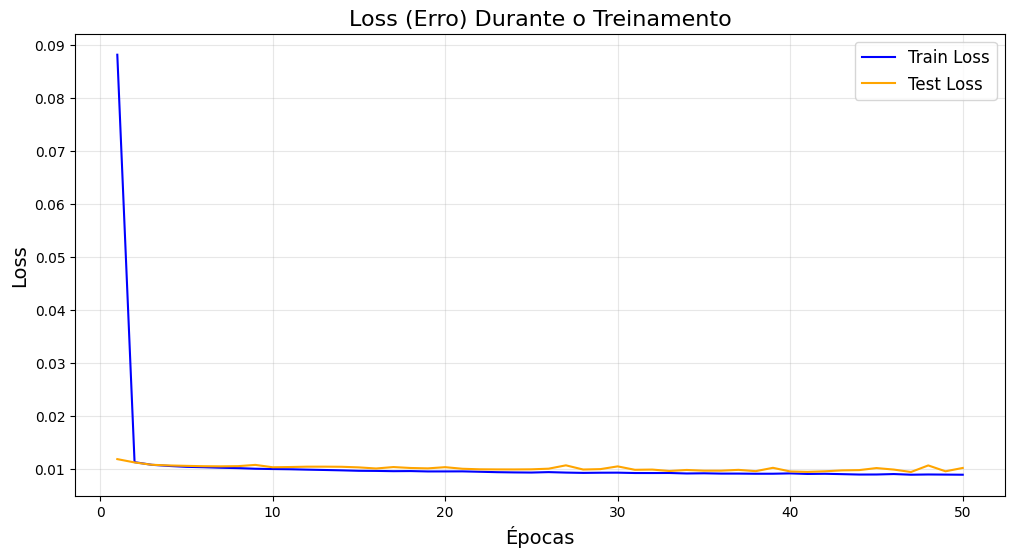

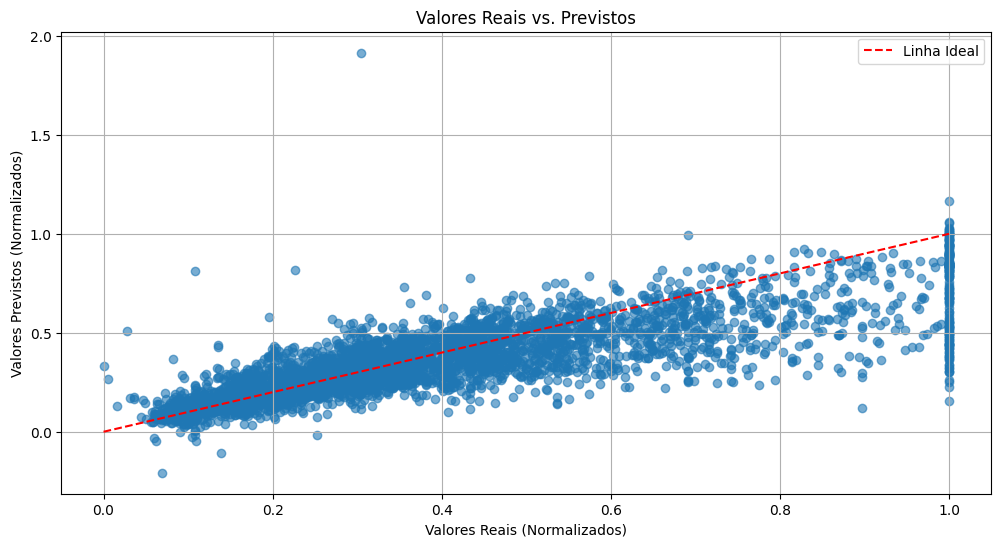

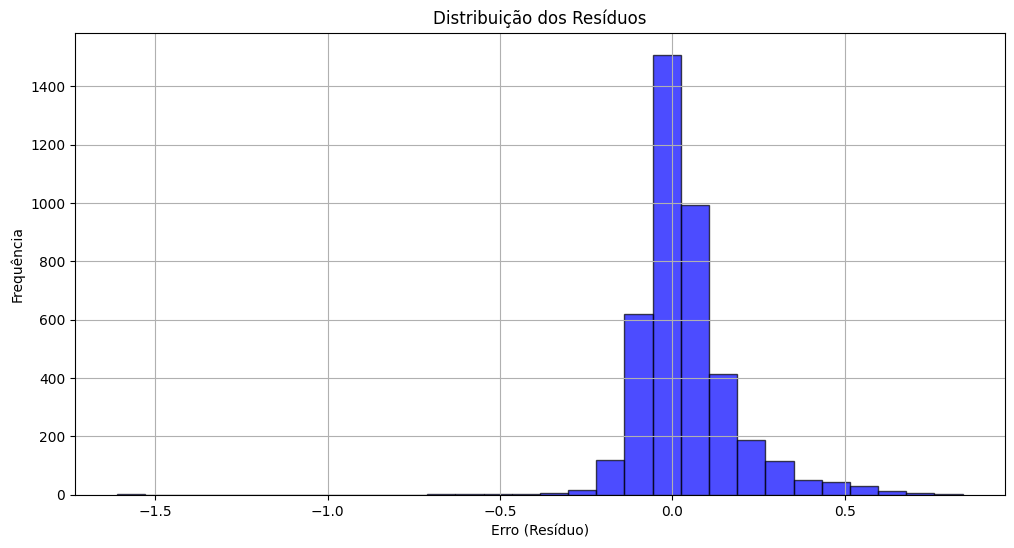

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Carregar o dataset
california_data = fetch_california_housing(as_frame=True)
california_df = california_data.frame

# Separar entradas (features) e saída (target)
X = california_df.drop("MedHouseVal", axis=1).values  # Entradas (features)
y = california_df["MedHouseVal"].values  # Saída (target)

# Normalizar os dados
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)  # Normaliza entre 0 e 1
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()  # Normaliza a saída entre 0 e 1

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Configurar a MLP
mlp = MLP(8, 64, 1, learning_rate=0.001)  # 8 features de entrada, 10 neurônios ocultos, 1 saída

# Treinar a MLP com os dados de treino e monitorar a loss (erro) em treino e teste
train_loss = []
test_loss = [] 

print("Treinando a MLP...")
epochs = 50  # Número de épocas
batch_size = 32  # Tamanho do mini-batch

for epoch in range(epochs):
    total_train_error = 0

    # Embaralhar os dados no início de cada época
    indices = np.arange(len(X_train))
    np.random.shuffle(indices)
    X_train = X_train[indices]
    y_train = y_train[indices]

    # Processar os mini-batches
    for i in range(0, len(X_train), batch_size):
        batch_inputs = X_train[i:i + batch_size]  # Mini-batch de entrada
        batch_outputs = y_train[i:i + batch_size].reshape(-1, 1)  # Mini-batch de saída (como matriz)

        # Propagação para frente e retropropagação
        mlp.forward_propagation(batch_inputs)  # (batch_size, input_size)
        mlp.backward_propagation(batch_outputs)  # (batch_size, output_size)

        # Acumular erro do treinamento
        total_train_error += np.sum((batch_outputs - mlp.outputs[-1]) ** 2) / 2

    # Calcular erro médio no conjunto de treino
    avg_train_error = total_train_error / len(X_train)
    train_loss.append(avg_train_error)

    # Cálculo do erro no conjunto de teste (test loss)
    total_test_error = 0
    for i in range(0, len(X_test), batch_size):
        batch_inputs = X_test[i:i + batch_size]
        batch_outputs = y_test[i:i + batch_size].reshape(-1, 1)
        predictions = mlp.forward_propagation(batch_inputs)
        total_test_error += np.sum((batch_outputs - predictions) ** 2) / 2

    avg_test_error = total_test_error / len(X_test)
    test_loss.append(avg_test_error)  # Armazenar o erro médio de teste

    print(f"Epoch {epoch + 1}, Train Loss: {avg_train_error:.6f}, Test Loss: {avg_test_error:.6f}")

# Testar o modelo diretamente pela classe MLP
predictions, mse, mae, r2 = mlp.test_model(X_test, y_test)

# Imprimir métricas
print("\nMétricas de Desempenho no Teste:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R² Score: {r2:.6f}")

# Plotar os erros do treino e do teste ao longo das épocas
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_loss, label="Train Loss", color='blue')
plt.plot(range(1, epochs + 1), test_loss, label="Test Loss", color='orange')

plt.title("Loss (Erro) Durante o Treinamento", fontsize=16)
plt.xlabel("Épocas", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Plotar valores reais vs previstos
plt.figure(figsize=(12, 6))
plt.scatter(y_test, predictions, alpha=0.6)
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Linha Ideal")
plt.title("Valores Reais vs. Previstos")
plt.xlabel("Valores Reais (Normalizados)")
plt.ylabel("Valores Previstos (Normalizados)")
plt.legend()
plt.grid()
plt.show()

# Plotar distribuições dos erros (resíduos)
residuals = [y_test[i] - predictions[i] for i in range(len(y_test))]
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, alpha=0.7, color="blue", edgecolor="black")
plt.title("Distribuição dos Resíduos")
plt.xlabel("Erro (Resíduo)")
plt.ylabel("Frequência")
plt.grid()
plt.show()

## learning rate 0.01 128 neuronios

Treinando a MLP...
Epoch 1, Train Loss: 32.136308, Test Loss: 0.032020
Epoch 2, Train Loss: 0.029524, Test Loss: 0.026705
Epoch 3, Train Loss: 0.013646, Test Loss: 0.011628
Epoch 4, Train Loss: 0.012158, Test Loss: 0.011119
Epoch 5, Train Loss: 0.012166, Test Loss: 0.011176
Epoch 6, Train Loss: 0.012128, Test Loss: 0.013021
Epoch 7, Train Loss: 0.012026, Test Loss: 0.011902
Epoch 8, Train Loss: 0.012242, Test Loss: 0.011218
Epoch 9, Train Loss: 0.012047, Test Loss: 0.016239
Epoch 10, Train Loss: 0.011960, Test Loss: 0.011459
Epoch 11, Train Loss: 0.012231, Test Loss: 0.011062
Epoch 12, Train Loss: 0.012148, Test Loss: 0.012357
Epoch 13, Train Loss: 0.012217, Test Loss: 0.011042
Epoch 14, Train Loss: 0.011943, Test Loss: 0.013454
Epoch 15, Train Loss: 0.012100, Test Loss: 0.010994
Epoch 16, Train Loss: 0.011942, Test Loss: 0.010876
Epoch 17, Train Loss: 0.011777, Test Loss: 0.011126
Epoch 18, Train Loss: 0.011714, Test Loss: 0.011941
Epoch 19, Train Loss: 0.012196, Test Loss: 0.011446
E

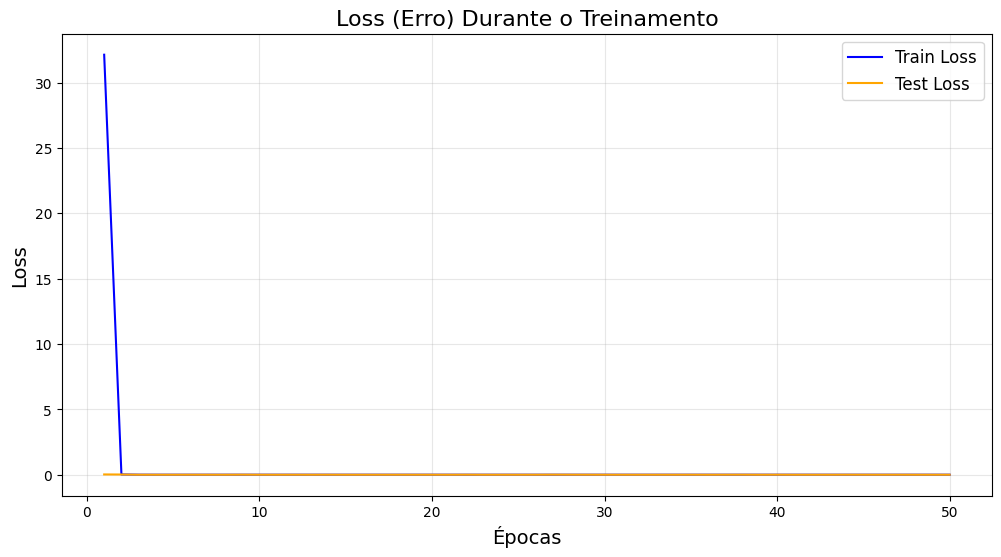

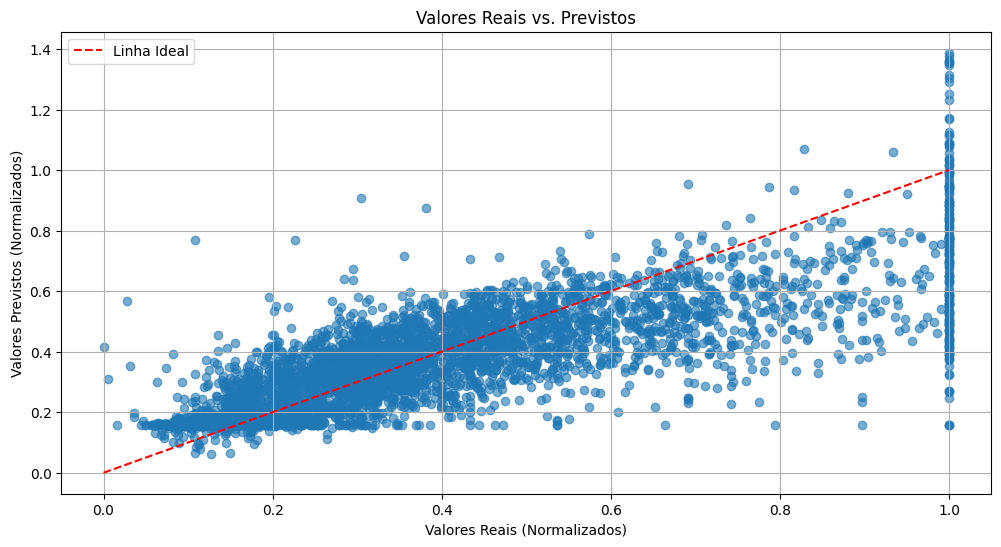

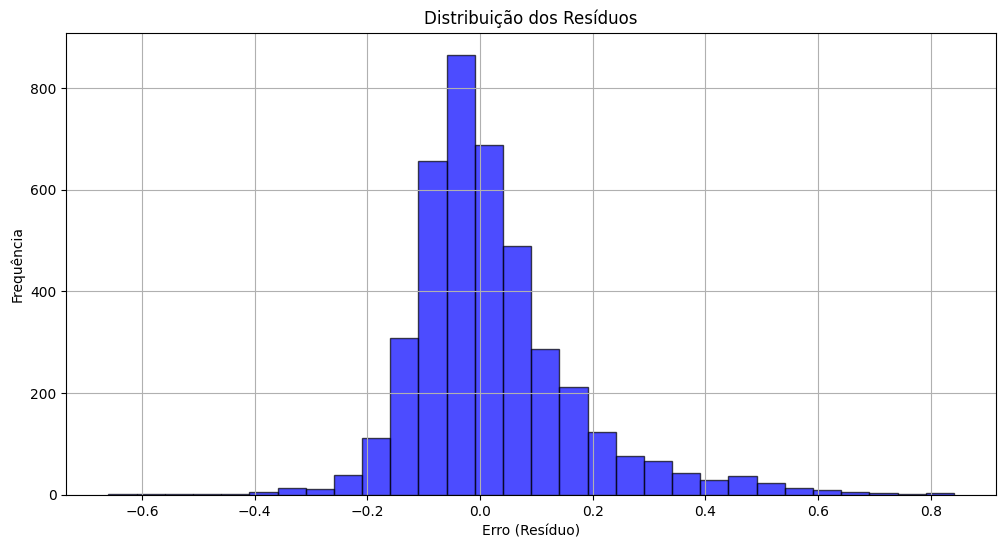

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Carregar o dataset
california_data = fetch_california_housing(as_frame=True)
california_df = california_data.frame

# Separar entradas (features) e saída (target)
X = california_df.drop("MedHouseVal", axis=1).values  # Entradas (features)
y = california_df["MedHouseVal"].values  # Saída (target)

# Normalizar os dados
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)  # Normaliza entre 0 e 1
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()  # Normaliza a saída entre 0 e 1

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Configurar a MLP
mlp = MLP(8, 128, 1, learning_rate=0.01)  # 8 features de entrada, 10 neurônios ocultos, 1 saída

# Treinar a MLP com os dados de treino e monitorar a loss (erro) em treino e teste
train_loss = []
test_loss = [] 

print("Treinando a MLP...")
epochs = 50  # Número de épocas
batch_size = 32  # Tamanho do mini-batch

for epoch in range(epochs):
    total_train_error = 0

    # Embaralhar os dados no início de cada época
    indices = np.arange(len(X_train))
    np.random.shuffle(indices)
    X_train = X_train[indices]
    y_train = y_train[indices]

    # Processar os mini-batches
    for i in range(0, len(X_train), batch_size):
        batch_inputs = X_train[i:i + batch_size]  # Mini-batch de entrada
        batch_outputs = y_train[i:i + batch_size].reshape(-1, 1)  # Mini-batch de saída (como matriz)

        # Propagação para frente e retropropagação
        mlp.forward_propagation(batch_inputs)  # (batch_size, input_size)
        mlp.backward_propagation(batch_outputs)  # (batch_size, output_size)

        # Acumular erro do treinamento
        total_train_error += np.sum((batch_outputs - mlp.outputs[-1]) ** 2) / 2

    # Calcular erro médio no conjunto de treino
    avg_train_error = total_train_error / len(X_train)
    train_loss.append(avg_train_error)

    # Cálculo do erro no conjunto de teste (test loss)
    total_test_error = 0
    for i in range(0, len(X_test), batch_size):
        batch_inputs = X_test[i:i + batch_size]
        batch_outputs = y_test[i:i + batch_size].reshape(-1, 1)
        predictions = mlp.forward_propagation(batch_inputs)
        total_test_error += np.sum((batch_outputs - predictions) ** 2) / 2

    avg_test_error = total_test_error / len(X_test)
    test_loss.append(avg_test_error)  # Armazenar o erro médio de teste

    print(f"Epoch {epoch + 1}, Train Loss: {avg_train_error:.6f}, Test Loss: {avg_test_error:.6f}")

# Testar o modelo diretamente pela classe MLP
predictions, mse, mae, r2 = mlp.test_model(X_test, y_test)

# Imprimir métricas
print("\nMétricas de Desempenho no Teste:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R² Score: {r2:.6f}")

# Plotar os erros do treino e do teste ao longo das épocas
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_loss, label="Train Loss", color='blue')
plt.plot(range(1, epochs + 1), test_loss, label="Test Loss", color='orange')

plt.title("Loss (Erro) Durante o Treinamento", fontsize=16)
plt.xlabel("Épocas", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Plotar valores reais vs previstos
plt.figure(figsize=(12, 6))
plt.scatter(y_test, predictions, alpha=0.6)
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Linha Ideal")
plt.title("Valores Reais vs. Previstos")
plt.xlabel("Valores Reais (Normalizados)")
plt.ylabel("Valores Previstos (Normalizados)")
plt.legend()
plt.grid()
plt.show()

# Plotar distribuições dos erros (resíduos)
residuals = [y_test[i] - predictions[i] for i in range(len(y_test))]
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, alpha=0.7, color="blue", edgecolor="black")
plt.title("Distribuição dos Resíduos")
plt.xlabel("Erro (Resíduo)")
plt.ylabel("Frequência")
plt.grid()
plt.show()

## learning rate 0.001 128 neuronios

Treinando a MLP...
Epoch 1, Train Loss: 0.080041, Test Loss: 0.010914
Epoch 2, Train Loss: 0.012057, Test Loss: 0.011014
Epoch 3, Train Loss: 0.011413, Test Loss: 0.010725
Epoch 4, Train Loss: 0.010889, Test Loss: 0.011448
Epoch 5, Train Loss: 0.010561, Test Loss: 0.010124
Epoch 6, Train Loss: 0.011053, Test Loss: 0.009861
Epoch 7, Train Loss: 0.010736, Test Loss: 0.010466
Epoch 8, Train Loss: 0.010109, Test Loss: 0.010111
Epoch 9, Train Loss: 0.010193, Test Loss: 0.011055
Epoch 10, Train Loss: 0.009941, Test Loss: 0.010594
Epoch 11, Train Loss: 0.010095, Test Loss: 0.009687
Epoch 12, Train Loss: 0.009820, Test Loss: 0.011430
Epoch 13, Train Loss: 0.009588, Test Loss: 0.009772
Epoch 14, Train Loss: 0.009843, Test Loss: 0.011332
Epoch 15, Train Loss: 0.009653, Test Loss: 0.011327
Epoch 16, Train Loss: 0.009922, Test Loss: 0.010204
Epoch 17, Train Loss: 0.009590, Test Loss: 0.009608
Epoch 18, Train Loss: 0.009853, Test Loss: 0.009629
Epoch 19, Train Loss: 0.009340, Test Loss: 0.010171
Ep

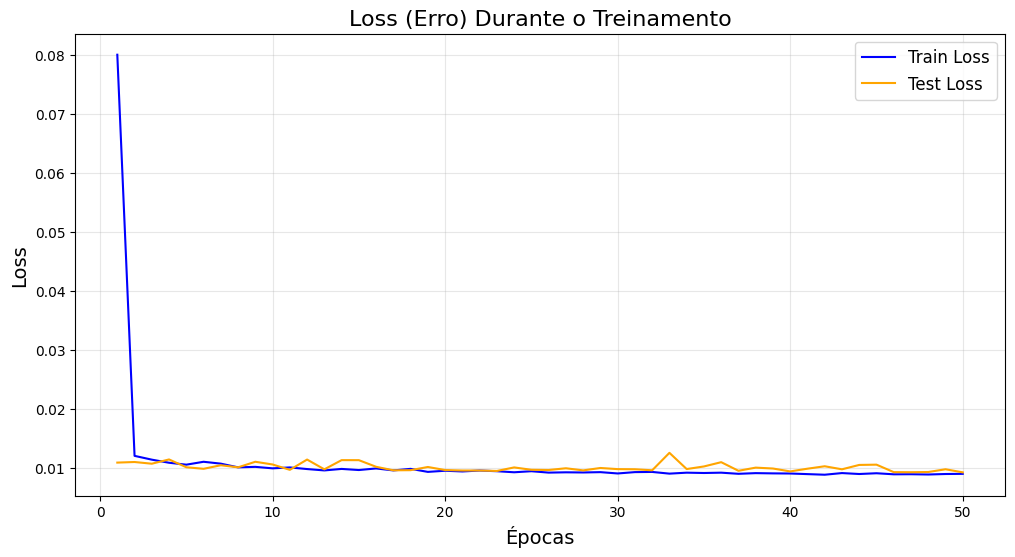

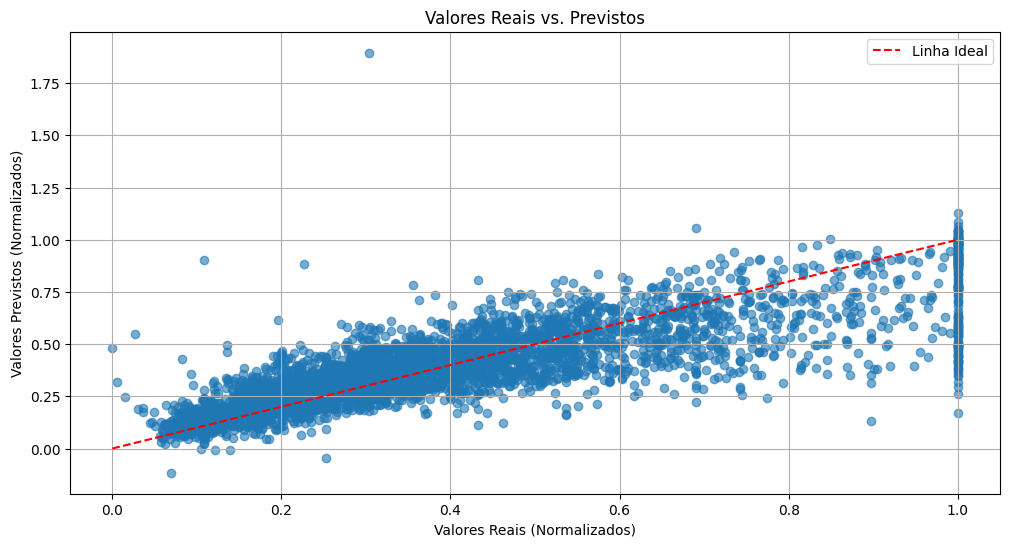

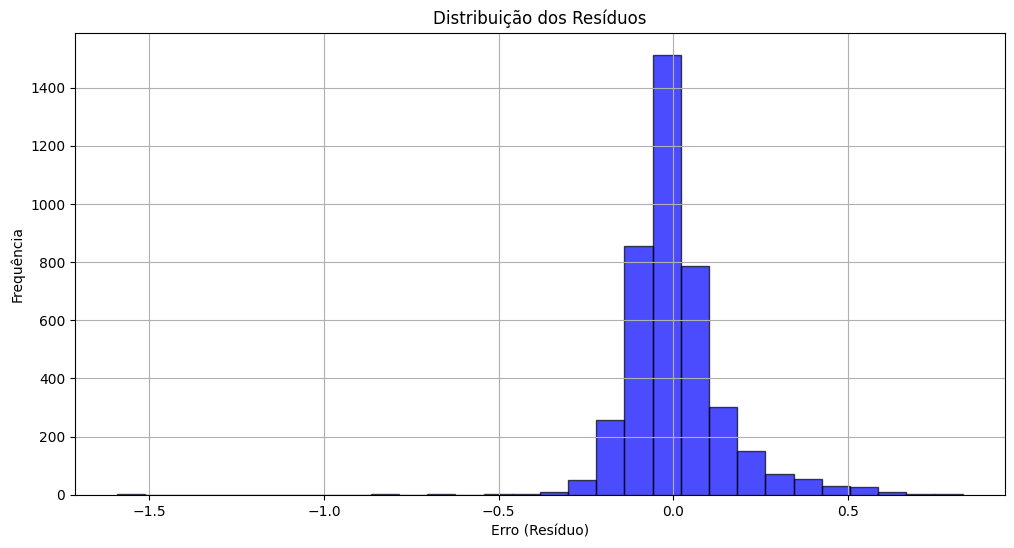

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Carregar o dataset
california_data = fetch_california_housing(as_frame=True)
california_df = california_data.frame

# Separar entradas (features) e saída (target)
X = california_df.drop("MedHouseVal", axis=1).values  # Entradas (features)
y = california_df["MedHouseVal"].values  # Saída (target)

# Normalizar os dados
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)  # Normaliza entre 0 e 1
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()  # Normaliza a saída entre 0 e 1

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Configurar a MLP
mlp = MLP(8, 128, 1, learning_rate=0.001)  # 8 features de entrada, 10 neurônios ocultos, 1 saída

# Treinar a MLP com os dados de treino e monitorar a loss (erro) em treino e teste
train_loss = []
test_loss = [] 

print("Treinando a MLP...")
epochs = 50  # Número de épocas
batch_size = 32  # Tamanho do mini-batch

for epoch in range(epochs):
    total_train_error = 0

    # Embaralhar os dados no início de cada época
    indices = np.arange(len(X_train))
    np.random.shuffle(indices)
    X_train = X_train[indices]
    y_train = y_train[indices]

    # Processar os mini-batches
    for i in range(0, len(X_train), batch_size):
        batch_inputs = X_train[i:i + batch_size]  # Mini-batch de entrada
        batch_outputs = y_train[i:i + batch_size].reshape(-1, 1)  # Mini-batch de saída (como matriz)

        # Propagação para frente e retropropagação
        mlp.forward_propagation(batch_inputs)  # (batch_size, input_size)
        mlp.backward_propagation(batch_outputs)  # (batch_size, output_size)

        # Acumular erro do treinamento
        total_train_error += np.sum((batch_outputs - mlp.outputs[-1]) ** 2) / 2

    # Calcular erro médio no conjunto de treino
    avg_train_error = total_train_error / len(X_train)
    train_loss.append(avg_train_error)

    # Cálculo do erro no conjunto de teste (test loss)
    total_test_error = 0
    for i in range(0, len(X_test), batch_size):
        batch_inputs = X_test[i:i + batch_size]
        batch_outputs = y_test[i:i + batch_size].reshape(-1, 1)
        predictions = mlp.forward_propagation(batch_inputs)
        total_test_error += np.sum((batch_outputs - predictions) ** 2) / 2

    avg_test_error = total_test_error / len(X_test)
    test_loss.append(avg_test_error)  # Armazenar o erro médio de teste

    print(f"Epoch {epoch + 1}, Train Loss: {avg_train_error:.6f}, Test Loss: {avg_test_error:.6f}")

# Testar o modelo diretamente pela classe MLP
predictions, mse, mae, r2 = mlp.test_model(X_test, y_test)

# Imprimir métricas
print("\nMétricas de Desempenho no Teste:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R² Score: {r2:.6f}")

# Plotar os erros do treino e do teste ao longo das épocas
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_loss, label="Train Loss", color='blue')
plt.plot(range(1, epochs + 1), test_loss, label="Test Loss", color='orange')

plt.title("Loss (Erro) Durante o Treinamento", fontsize=16)
plt.xlabel("Épocas", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Plotar valores reais vs previstos
plt.figure(figsize=(12, 6))
plt.scatter(y_test, predictions, alpha=0.6)
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Linha Ideal")
plt.title("Valores Reais vs. Previstos")
plt.xlabel("Valores Reais (Normalizados)")
plt.ylabel("Valores Previstos (Normalizados)")
plt.legend()
plt.grid()
plt.show()

# Plotar distribuições dos erros (resíduos)
residuals = [y_test[i] - predictions[i] for i in range(len(y_test))]
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, alpha=0.7, color="blue", edgecolor="black")
plt.title("Distribuição dos Resíduos")
plt.xlabel("Erro (Resíduo)")
plt.ylabel("Frequência")
plt.grid()
plt.show()

## adicionando uma camada oculta

Treinando a MLP...
Epoch 1, Train Loss: 0.050120, Test Loss: 0.014682
Epoch 2, Train Loss: 0.011806, Test Loss: 0.011087
Epoch 3, Train Loss: 0.010760, Test Loss: 0.011053
Epoch 4, Train Loss: 0.010487, Test Loss: 0.010597
Epoch 5, Train Loss: 0.010552, Test Loss: 0.010531
Epoch 6, Train Loss: 0.010445, Test Loss: 0.011242
Epoch 7, Train Loss: 0.010471, Test Loss: 0.010508
Epoch 8, Train Loss: 0.010338, Test Loss: 0.010413
Epoch 9, Train Loss: 0.010402, Test Loss: 0.010393
Epoch 10, Train Loss: 0.010236, Test Loss: 0.010484
Epoch 11, Train Loss: 0.010326, Test Loss: 0.010494
Epoch 12, Train Loss: 0.010267, Test Loss: 0.011098
Epoch 13, Train Loss: 0.010217, Test Loss: 0.010696
Epoch 14, Train Loss: 0.010201, Test Loss: 0.010395
Epoch 15, Train Loss: 0.010211, Test Loss: 0.010713
Epoch 16, Train Loss: 0.010171, Test Loss: 0.010397
Epoch 17, Train Loss: 0.010278, Test Loss: 0.010383
Epoch 18, Train Loss: 0.010184, Test Loss: 0.010496
Epoch 19, Train Loss: 0.010205, Test Loss: 0.010404
Ep

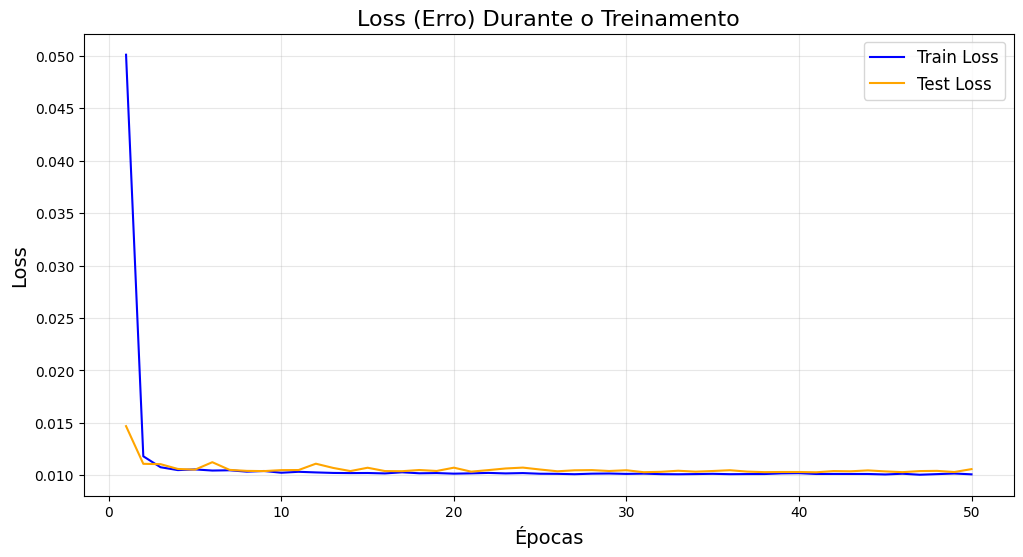

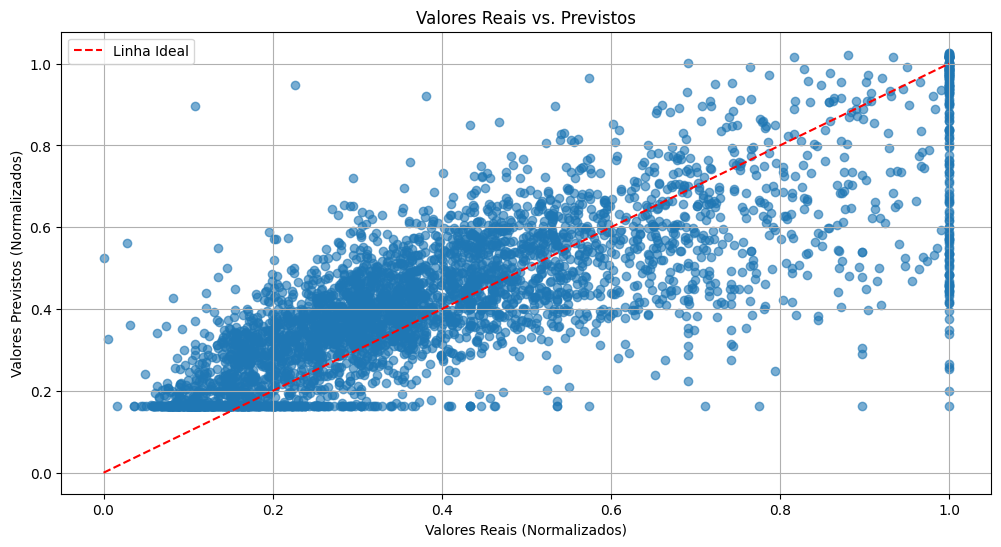

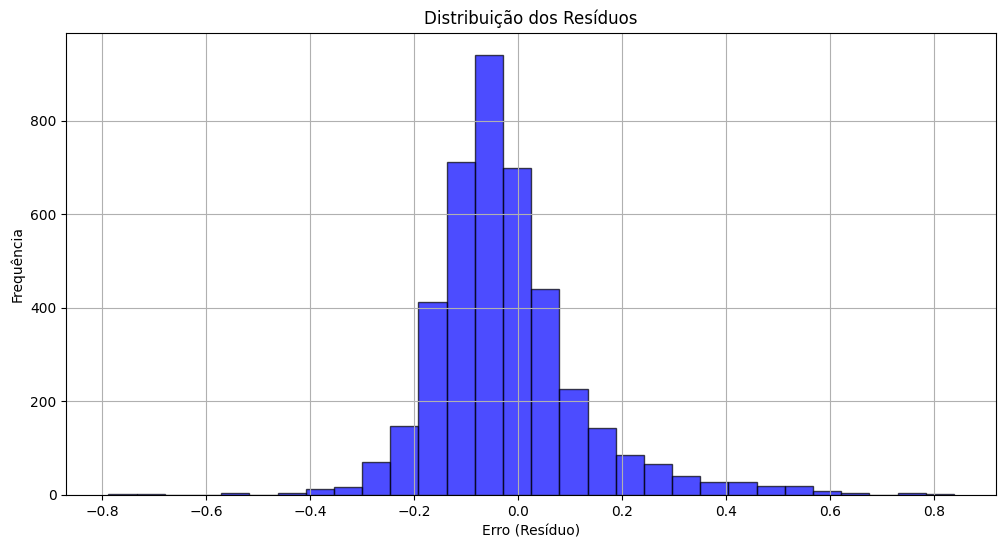

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Carregar o dataset
california_data = fetch_california_housing(as_frame=True)
california_df = california_data.frame

# Separar entradas (features) e saída (target)
X = california_df.drop("MedHouseVal", axis=1).values  # Entradas (features)
y = california_df["MedHouseVal"].values  # Saída (target)

# Normalizar os dados
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)  # Normaliza entre 0 e 1
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()  # Normaliza a saída entre 0 e 1

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Configurar a MLP
mlp = MLP(8, 10, 10, 1, learning_rate=0.001)  # 8 features de entrada, 10 neurônios ocultos, 1 saída

# Treinar a MLP com os dados de treino e monitorar a loss (erro) em treino e teste
train_loss = []
test_loss = [] 

print("Treinando a MLP...")
epochs = 50  # Número de épocas
batch_size = 32  # Tamanho do mini-batch

for epoch in range(epochs):
    total_train_error = 0

    # Embaralhar os dados no início de cada época
    indices = np.arange(len(X_train))
    np.random.shuffle(indices)
    X_train = X_train[indices]
    y_train = y_train[indices]

    # Processar os mini-batches
    for i in range(0, len(X_train), batch_size):
        batch_inputs = X_train[i:i + batch_size]  # Mini-batch de entrada
        batch_outputs = y_train[i:i + batch_size].reshape(-1, 1)  # Mini-batch de saída (como matriz)

        # Propagação para frente e retropropagação
        mlp.forward_propagation(batch_inputs)  # (batch_size, input_size)
        mlp.backward_propagation(batch_outputs)  # (batch_size, output_size)

        # Acumular erro do treinamento
        total_train_error += np.sum((batch_outputs - mlp.outputs[-1]) ** 2) / 2

    # Calcular erro médio no conjunto de treino
    avg_train_error = total_train_error / len(X_train)
    train_loss.append(avg_train_error)

    # Cálculo do erro no conjunto de teste (test loss)
    total_test_error = 0
    for i in range(0, len(X_test), batch_size):
        batch_inputs = X_test[i:i + batch_size]
        batch_outputs = y_test[i:i + batch_size].reshape(-1, 1)
        predictions = mlp.forward_propagation(batch_inputs)
        total_test_error += np.sum((batch_outputs - predictions) ** 2) / 2

    avg_test_error = total_test_error / len(X_test)
    test_loss.append(avg_test_error)  # Armazenar o erro médio de teste

    print(f"Epoch {epoch + 1}, Train Loss: {avg_train_error:.6f}, Test Loss: {avg_test_error:.6f}")

# Testar o modelo diretamente pela classe MLP
predictions, mse, mae, r2 = mlp.test_model(X_test, y_test)

# Imprimir métricas
print("\nMétricas de Desempenho no Teste:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R² Score: {r2:.6f}")

# Plotar os erros do treino e do teste ao longo das épocas
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_loss, label="Train Loss", color='blue')
plt.plot(range(1, epochs + 1), test_loss, label="Test Loss", color='orange')

plt.title("Loss (Erro) Durante o Treinamento", fontsize=16)
plt.xlabel("Épocas", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Plotar valores reais vs previstos
plt.figure(figsize=(12, 6))
plt.scatter(y_test, predictions, alpha=0.6)
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Linha Ideal")
plt.title("Valores Reais vs. Previstos")
plt.xlabel("Valores Reais (Normalizados)")
plt.ylabel("Valores Previstos (Normalizados)")
plt.legend()
plt.grid()
plt.show()

# Plotar distribuições dos erros (resíduos)
residuals = [y_test[i] - predictions[i] for i in range(len(y_test))]
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, alpha=0.7, color="blue", edgecolor="black")
plt.title("Distribuição dos Resíduos")
plt.xlabel("Erro (Resíduo)")
plt.ylabel("Frequência")
plt.grid()
plt.show()

## 32 neuronios 32 neuronios

Treinando a MLP...
Epoch 1, Train Loss: 0.047406, Test Loss: 0.012283
Epoch 2, Train Loss: 0.012147, Test Loss: 0.013627
Epoch 3, Train Loss: 0.011528, Test Loss: 0.014845
Epoch 4, Train Loss: 0.011055, Test Loss: 0.010971
Epoch 5, Train Loss: 0.010786, Test Loss: 0.010936
Epoch 6, Train Loss: 0.010725, Test Loss: 0.010559
Epoch 7, Train Loss: 0.010646, Test Loss: 0.010414
Epoch 8, Train Loss: 0.010531, Test Loss: 0.011036
Epoch 9, Train Loss: 0.010313, Test Loss: 0.010402
Epoch 10, Train Loss: 0.010381, Test Loss: 0.010395
Epoch 11, Train Loss: 0.010258, Test Loss: 0.010611
Epoch 12, Train Loss: 0.010284, Test Loss: 0.010700
Epoch 13, Train Loss: 0.010255, Test Loss: 0.010311
Epoch 14, Train Loss: 0.010120, Test Loss: 0.010319
Epoch 15, Train Loss: 0.010136, Test Loss: 0.010240
Epoch 16, Train Loss: 0.010102, Test Loss: 0.010384
Epoch 17, Train Loss: 0.009996, Test Loss: 0.010247
Epoch 18, Train Loss: 0.009992, Test Loss: 0.011020
Epoch 19, Train Loss: 0.010004, Test Loss: 0.010590
Ep

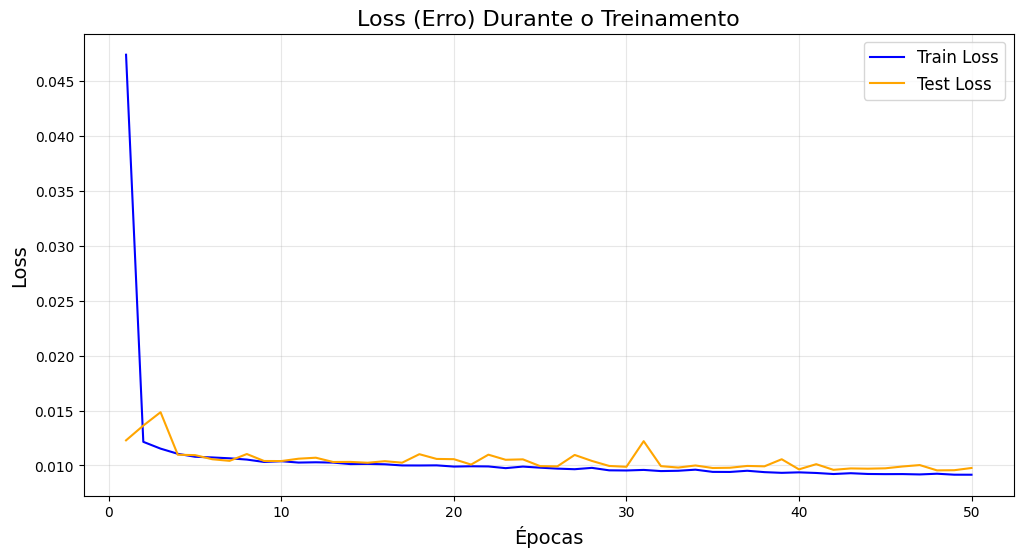

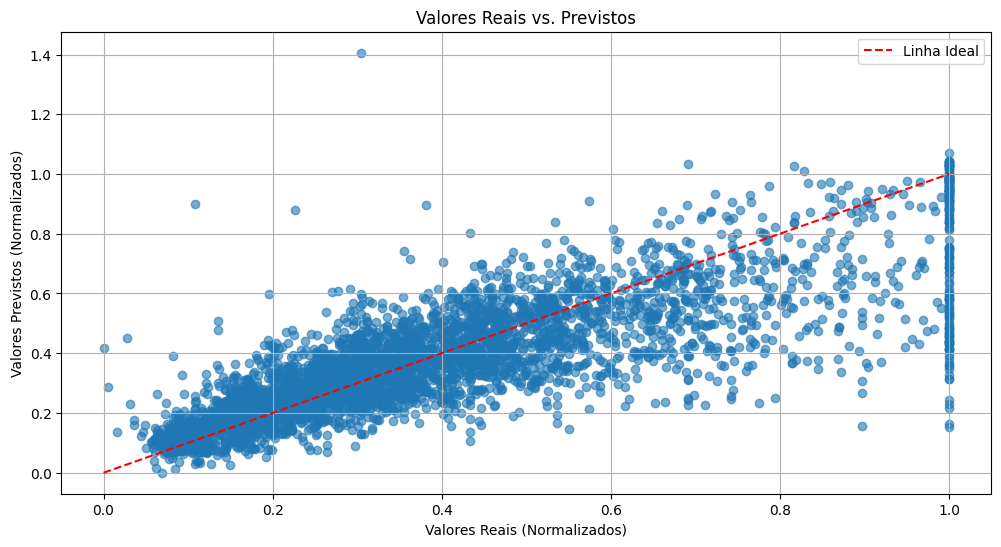

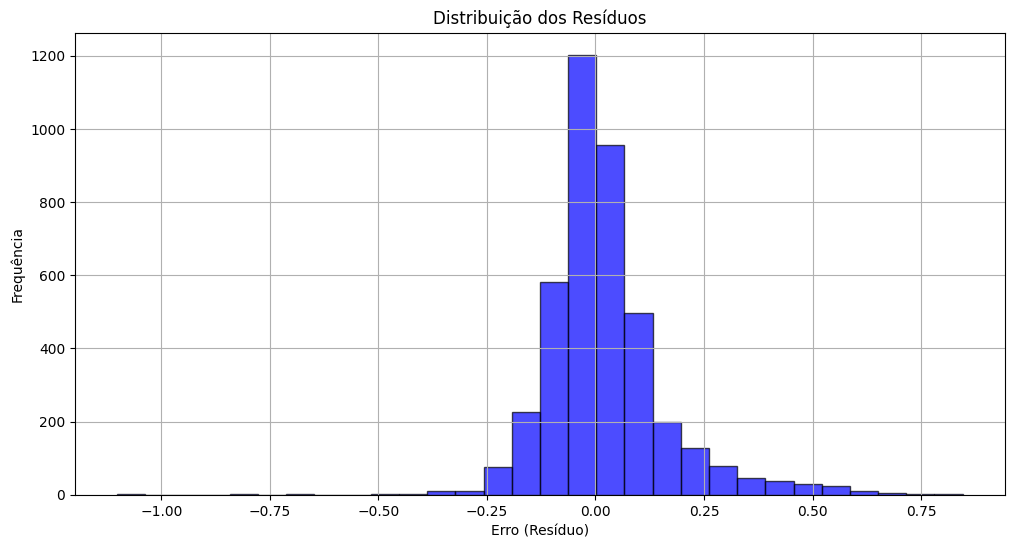

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Carregar o dataset
california_data = fetch_california_housing(as_frame=True)
california_df = california_data.frame

# Separar entradas (features) e saída (target)
X = california_df.drop("MedHouseVal", axis=1).values  # Entradas (features)
y = california_df["MedHouseVal"].values  # Saída (target)

# Normalizar os dados
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)  # Normaliza entre 0 e 1
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()  # Normaliza a saída entre 0 e 1

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Configurar a MLP
mlp = MLP(8, 32, 32, 1, learning_rate=0.001)  # 8 features de entrada, 10 neurônios ocultos, 1 saída

# Treinar a MLP com os dados de treino e monitorar a loss (erro) em treino e teste
train_loss = []
test_loss = [] 

print("Treinando a MLP...")
epochs = 50  # Número de épocas
batch_size = 32  # Tamanho do mini-batch

for epoch in range(epochs):
    total_train_error = 0

    # Embaralhar os dados no início de cada época
    indices = np.arange(len(X_train))
    np.random.shuffle(indices)
    X_train = X_train[indices]
    y_train = y_train[indices]

    # Processar os mini-batches
    for i in range(0, len(X_train), batch_size):
        batch_inputs = X_train[i:i + batch_size]  # Mini-batch de entrada
        batch_outputs = y_train[i:i + batch_size].reshape(-1, 1)  # Mini-batch de saída (como matriz)

        # Propagação para frente e retropropagação
        mlp.forward_propagation(batch_inputs)  # (batch_size, input_size)
        mlp.backward_propagation(batch_outputs)  # (batch_size, output_size)

        # Acumular erro do treinamento
        total_train_error += np.sum((batch_outputs - mlp.outputs[-1]) ** 2) / 2

    # Calcular erro médio no conjunto de treino
    avg_train_error = total_train_error / len(X_train)
    train_loss.append(avg_train_error)

    # Cálculo do erro no conjunto de teste (test loss)
    total_test_error = 0
    for i in range(0, len(X_test), batch_size):
        batch_inputs = X_test[i:i + batch_size]
        batch_outputs = y_test[i:i + batch_size].reshape(-1, 1)
        predictions = mlp.forward_propagation(batch_inputs)
        total_test_error += np.sum((batch_outputs - predictions) ** 2) / 2

    avg_test_error = total_test_error / len(X_test)
    test_loss.append(avg_test_error)  # Armazenar o erro médio de teste

    print(f"Epoch {epoch + 1}, Train Loss: {avg_train_error:.6f}, Test Loss: {avg_test_error:.6f}")

# Testar o modelo diretamente pela classe MLP
predictions, mse, mae, r2 = mlp.test_model(X_test, y_test)

# Imprimir métricas
print("\nMétricas de Desempenho no Teste:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R² Score: {r2:.6f}")

# Plotar os erros do treino e do teste ao longo das épocas
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_loss, label="Train Loss", color='blue')
plt.plot(range(1, epochs + 1), test_loss, label="Test Loss", color='orange')

plt.title("Loss (Erro) Durante o Treinamento", fontsize=16)
plt.xlabel("Épocas", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Plotar valores reais vs previstos
plt.figure(figsize=(12, 6))
plt.scatter(y_test, predictions, alpha=0.6)
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Linha Ideal")
plt.title("Valores Reais vs. Previstos")
plt.xlabel("Valores Reais (Normalizados)")
plt.ylabel("Valores Previstos (Normalizados)")
plt.legend()
plt.grid()
plt.show()

# Plotar distribuições dos erros (resíduos)
residuals = [y_test[i] - predictions[i] for i in range(len(y_test))]
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, alpha=0.7, color="blue", edgecolor="black")
plt.title("Distribuição dos Resíduos")
plt.xlabel("Erro (Resíduo)")
plt.ylabel("Frequência")
plt.grid()
plt.show()

## 32 neuronios 64 neuronios

Treinando a MLP...
Epoch 1, Train Loss: 2.716693, Test Loss: 0.027855
Epoch 2, Train Loss: 0.029702, Test Loss: 0.035411
Epoch 3, Train Loss: 0.029640, Test Loss: 0.029317
Epoch 4, Train Loss: 0.029151, Test Loss: 0.028241
Epoch 5, Train Loss: 0.029379, Test Loss: 0.027890
Epoch 6, Train Loss: 0.029300, Test Loss: 0.027875
Epoch 7, Train Loss: 0.029754, Test Loss: 0.027855
Epoch 8, Train Loss: 0.029148, Test Loss: 0.027868
Epoch 9, Train Loss: 0.029449, Test Loss: 0.030402
Epoch 10, Train Loss: 0.029298, Test Loss: 0.027967
Epoch 11, Train Loss: 0.029153, Test Loss: 0.029577
Epoch 12, Train Loss: 0.029360, Test Loss: 0.031338
Epoch 13, Train Loss: 0.029370, Test Loss: 0.028207
Epoch 14, Train Loss: 0.029294, Test Loss: 0.027904
Epoch 15, Train Loss: 0.029373, Test Loss: 0.028251
Epoch 16, Train Loss: 0.029145, Test Loss: 0.029124
Epoch 17, Train Loss: 0.029133, Test Loss: 0.027891
Epoch 18, Train Loss: 0.029174, Test Loss: 0.028072
Epoch 19, Train Loss: 0.029335, Test Loss: 0.028091
Ep

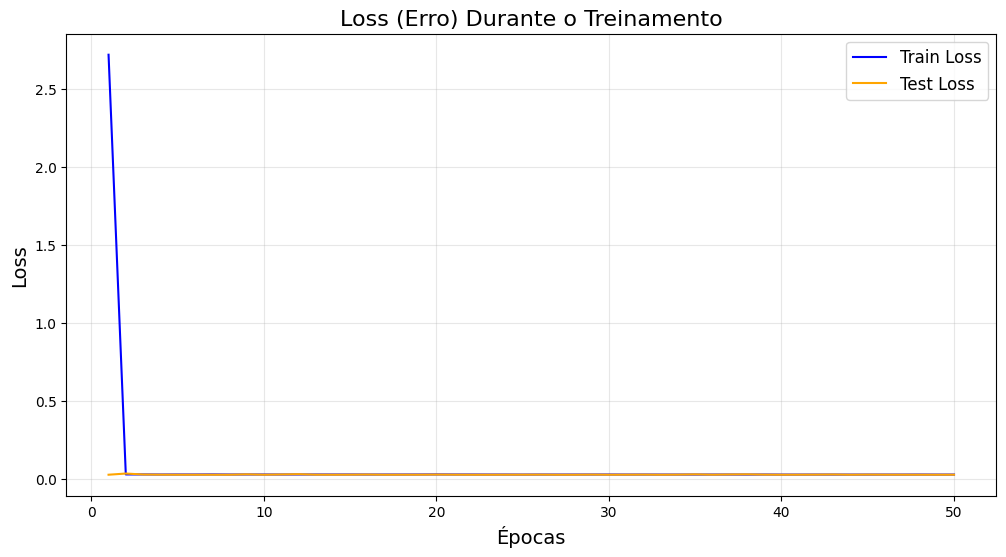

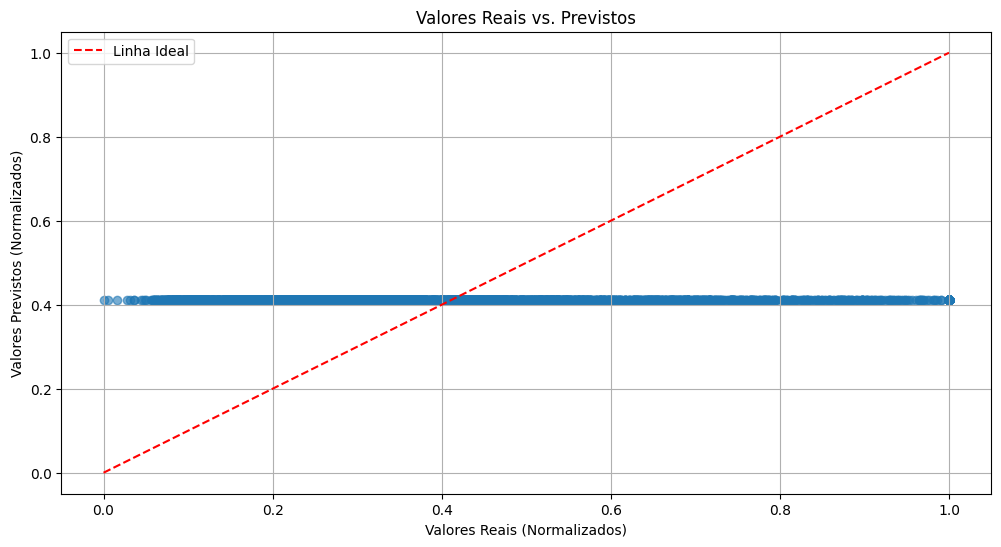

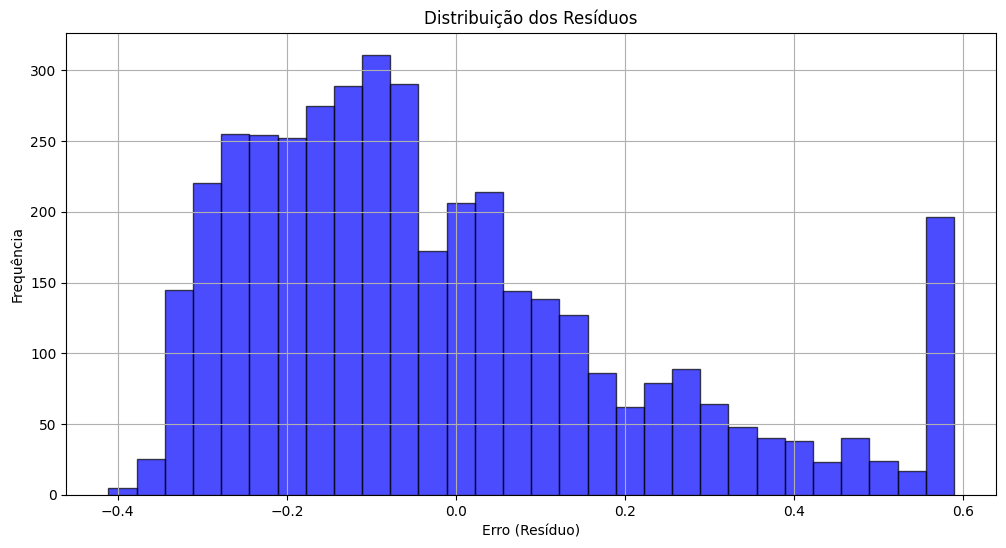

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Carregar o dataset
california_data = fetch_california_housing(as_frame=True)
california_df = california_data.frame

# Separar entradas (features) e saída (target)
X = california_df.drop("MedHouseVal", axis=1).values  # Entradas (features)
y = california_df["MedHouseVal"].values  # Saída (target)

# Normalizar os dados
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)  # Normaliza entre 0 e 1
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()  # Normaliza a saída entre 0 e 1

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Configurar a MLP
mlp = MLP(8, 32, 64, 1, learning_rate=0.001)  # 8 features de entrada, 10 neurônios ocultos, 1 saída

# Treinar a MLP com os dados de treino e monitorar a loss (erro) em treino e teste
train_loss = []
test_loss = [] 

print("Treinando a MLP...")
epochs = 50  # Número de épocas
batch_size = 32  # Tamanho do mini-batch

for epoch in range(epochs):
    total_train_error = 0

    # Embaralhar os dados no início de cada época
    indices = np.arange(len(X_train))
    np.random.shuffle(indices)
    X_train = X_train[indices]
    y_train = y_train[indices]

    # Processar os mini-batches
    for i in range(0, len(X_train), batch_size):
        batch_inputs = X_train[i:i + batch_size]  # Mini-batch de entrada
        batch_outputs = y_train[i:i + batch_size].reshape(-1, 1)  # Mini-batch de saída (como matriz)

        # Propagação para frente e retropropagação
        mlp.forward_propagation(batch_inputs)  # (batch_size, input_size)
        mlp.backward_propagation(batch_outputs)  # (batch_size, output_size)

        # Acumular erro do treinamento
        total_train_error += np.sum((batch_outputs - mlp.outputs[-1]) ** 2) / 2

    # Calcular erro médio no conjunto de treino
    avg_train_error = total_train_error / len(X_train)
    train_loss.append(avg_train_error)

    # Cálculo do erro no conjunto de teste (test loss)
    total_test_error = 0
    for i in range(0, len(X_test), batch_size):
        batch_inputs = X_test[i:i + batch_size]
        batch_outputs = y_test[i:i + batch_size].reshape(-1, 1)
        predictions = mlp.forward_propagation(batch_inputs)
        total_test_error += np.sum((batch_outputs - predictions) ** 2) / 2

    avg_test_error = total_test_error / len(X_test)
    test_loss.append(avg_test_error)  # Armazenar o erro médio de teste

    print(f"Epoch {epoch + 1}, Train Loss: {avg_train_error:.6f}, Test Loss: {avg_test_error:.6f}")

# Testar o modelo diretamente pela classe MLP
predictions, mse, mae, r2 = mlp.test_model(X_test, y_test)

# Imprimir métricas
print("\nMétricas de Desempenho no Teste:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R² Score: {r2:.6f}")

# Plotar os erros do treino e do teste ao longo das épocas
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_loss, label="Train Loss", color='blue')
plt.plot(range(1, epochs + 1), test_loss, label="Test Loss", color='orange')

plt.title("Loss (Erro) Durante o Treinamento", fontsize=16)
plt.xlabel("Épocas", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Plotar valores reais vs previstos
plt.figure(figsize=(12, 6))
plt.scatter(y_test, predictions, alpha=0.6)
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Linha Ideal")
plt.title("Valores Reais vs. Previstos")
plt.xlabel("Valores Reais (Normalizados)")
plt.ylabel("Valores Previstos (Normalizados)")
plt.legend()
plt.grid()
plt.show()

# Plotar distribuições dos erros (resíduos)
residuals = [y_test[i] - predictions[i] for i in range(len(y_test))]
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, alpha=0.7, color="blue", edgecolor="black")
plt.title("Distribuição dos Resíduos")
plt.xlabel("Erro (Resíduo)")
plt.ylabel("Frequência")
plt.grid()
plt.show()